# **Data Loading & Cleaning**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import pearsonr
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
df = pd.read_csv('Airline_Delay_Cause.csv')
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())

Dataset shape: (179338, 21)

Column names:
['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name', 'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']


In [ ]:
def data_quality_analysis(df):
    """Comprehensive data quality assessment"""

    print("="*60)
    print("DATA QUALITY & STRUCTURE ANALYSIS")
    print("="*60)

    print(f"Dataset shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    print("\n--- MISSING VALUES ANALYSIS ---")
    missing_data = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
        'Data_Type': df.dtypes
    })
    missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

    if len(missing_data) > 0:
        print(missing_data)
    else:
        print("No missing values found!")

    print("\n--- DATA TYPE VALIDATION ---")
    numeric_cols = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
                   'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
                   'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
                   'security_delay', 'late_aircraft_delay']

    for col in numeric_cols:
        if col in df.columns:
            if not pd.api.types.is_numeric_dtype(df[col]):
                print(f"WARNING: {col} is not numeric! Current type: {df[col].dtype}")
            else:
                print(f"✓ {col}: {df[col].dtype}")

    print("\n--- DUPLICATE ANALYSIS ---")
    key_cols = ['year', 'month', 'carrier', 'airport']
    duplicates = df[df.duplicated(subset=key_cols, keep=False)]
    print(f"Duplicate rows found: {len(duplicates)}")

    if len(duplicates) > 0:
        print("Duplicate entries:")
        print(duplicates[key_cols + ['carrier_name', 'airport_name']])

    print("\n--- ZERO-FLIGHT VALIDATION ---")
    zero_flights = df[df['arr_flights'] == 0]
    print(f"Rows with zero flights: {len(zero_flights)}")

    if len(zero_flights) > 0:
        print("Zero flight entries:")
        print(zero_flights[['carrier_name', 'airport_name', 'month', 'arr_flights']])

    print("\n--- BASIC STATISTICS ---")
    print(df[numeric_cols].describe())

    return missing_data, duplicates, zero_flights

missing_data, duplicates, zero_flights = data_quality_analysis(df)

DATA QUALITY & STRUCTURE ANALYSIS
Dataset shape: (179338, 21)
Memory usage: 73.64 MB

--- MISSING VALUES ANALYSIS ---
                                  Column  Missing_Count  Missing_Percentage Data_Type
arr_del15                      arr_del15            591            0.329545   float64
arr_flights                  arr_flights            341            0.190144   float64
carrier_ct                    carrier_ct            341            0.190144   float64
weather_ct                    weather_ct            341            0.190144   float64
nas_ct                            nas_ct            341            0.190144   float64
security_ct                  security_ct            341            0.190144   float64
late_aircraft_ct        late_aircraft_ct            341            0.190144   float64
arr_cancelled              arr_cancelled            341            0.190144   float64
arr_diverted                arr_diverted            341            0.190144   float64
arr_delay             

# **Exploratory Data Analysis (EDA)**

In [ ]:
def aggregate_trends_analysis(df):
    """Analyze aggregate trends and patterns"""

    print("\n" + "="*60)
    print("AGGREGATE TRENDS ANALYSIS")
    print("="*60)

    df['delay_rate'] = (df['arr_del15'] / df['arr_flights']) * 100
    df['delay_rate'] = df['delay_rate'].fillna(0)


    df['avg_delay_per_flight'] = df['arr_delay'] / df['arr_flights']
    df['avg_delay_per_flight'] = df['avg_delay_per_flight'].fillna(0)


    df['cancellation_rate'] = (df['arr_cancelled'] / df['arr_flights']) * 100
    df['cancellation_rate'] = df['cancellation_rate'].fillna(0)


    print("\n--- MONTHLY DELAY RATES BY CARRIER ---")
    carrier_trends = df.groupby(['carrier_name', 'month']).agg({
        'arr_flights': 'sum',
        'arr_del15': 'sum',
        'arr_delay': 'sum',
        'arr_cancelled': 'sum'
    }).reset_index()

    carrier_trends['delay_rate'] = (carrier_trends['arr_del15'] / carrier_trends['arr_flights']) * 100
    carrier_trends['avg_delay_per_flight'] = carrier_trends['arr_delay'] / carrier_trends['arr_flights']
    carrier_trends['cancellation_rate'] = (carrier_trends['arr_cancelled'] / carrier_trends['arr_flights']) * 100

    print(carrier_trends)

    print("\n--- CARRIER PERFORMANCE SUMMARY ---")
    carrier_summary = df.groupby('carrier_name').agg({
        'arr_flights': 'sum',
        'arr_del15': 'sum',
        'arr_delay': 'sum',
        'arr_cancelled': 'sum',
        'delay_rate': 'mean',
        'avg_delay_per_flight': 'mean',
        'cancellation_rate': 'mean'
    }).round(2)

    carrier_summary = carrier_summary.sort_values('delay_rate', ascending=False)
    print(carrier_summary)

    return carrier_trends, carrier_summary

carrier_trends, carrier_summary = aggregate_trends_analysis(df)


AGGREGATE TRENDS ANALYSIS

--- MONTHLY DELAY RATES BY CARRIER ---
                    carrier_name  month  arr_flights  arr_del15  arr_delay  arr_cancelled  delay_rate  avg_delay_per_flight  cancellation_rate
0    Air Wisconsin Airlines Corp      1      40670.0     8312.0   692093.0         2484.0   20.437669             17.017285           6.107696
1    Air Wisconsin Airlines Corp      2      38285.0     7981.0   722260.0         2048.0   20.846284             18.865352           5.349354
2    Air Wisconsin Airlines Corp      3      44085.0     5339.0   404839.0         2215.0   12.110695              9.183146           5.024385
3    Air Wisconsin Airlines Corp      4      37207.0     5170.0   431684.0         1679.0   13.895235             11.602225           4.512592
4    Air Wisconsin Airlines Corp      5      36426.0     6325.0   563870.0          841.0   17.363971             15.479877           2.308790
..                           ...    ...          ...        ...        ... 

<Figure size 1000x600 with 0 Axes>

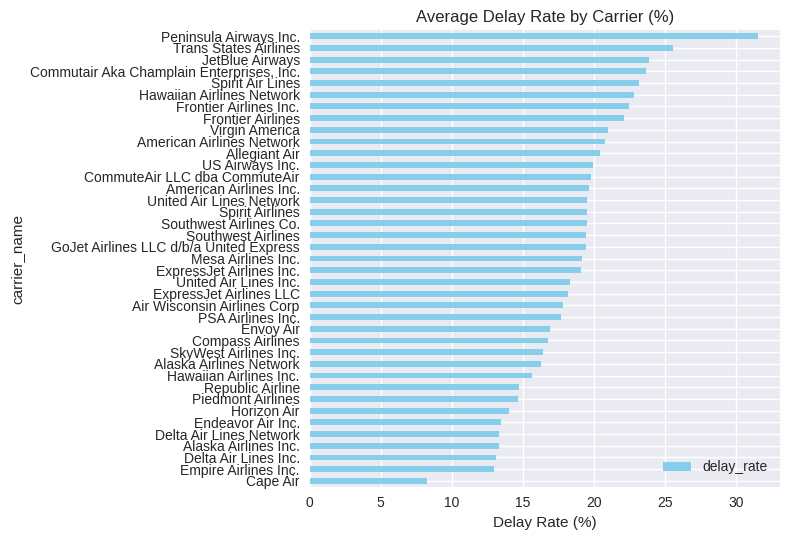

In [ ]:
plt.figure(figsize=(10, 6))
carrier_summary.sort_values('delay_rate', ascending=True).plot(
    y='delay_rate', kind='barh', color='skyblue'
)
plt.title('Average Delay Rate by Carrier (%)')
plt.xlabel('Delay Rate (%)')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

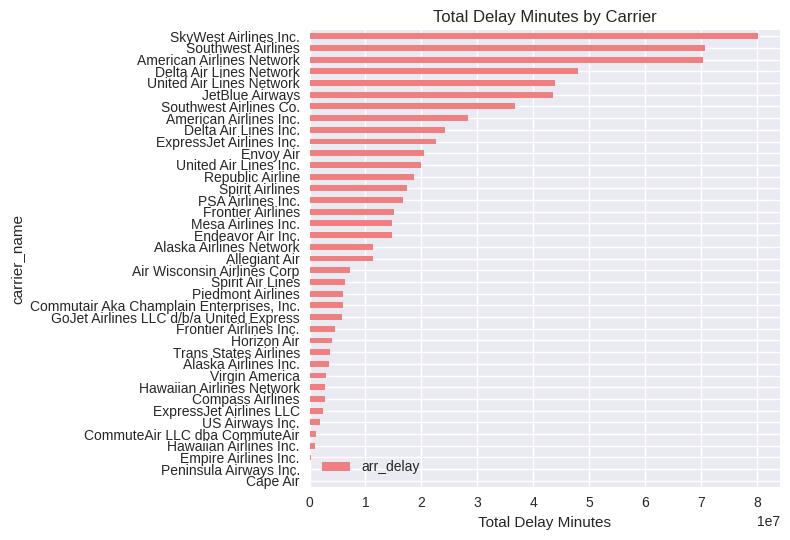

In [ ]:
plt.figure(figsize=(10, 6))
carrier_summary.sort_values('arr_delay', ascending=True).plot(
    y='arr_delay', kind='barh', color='lightcoral'
)
plt.title('Total Delay Minutes by Carrier')
plt.xlabel('Total Delay Minutes')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

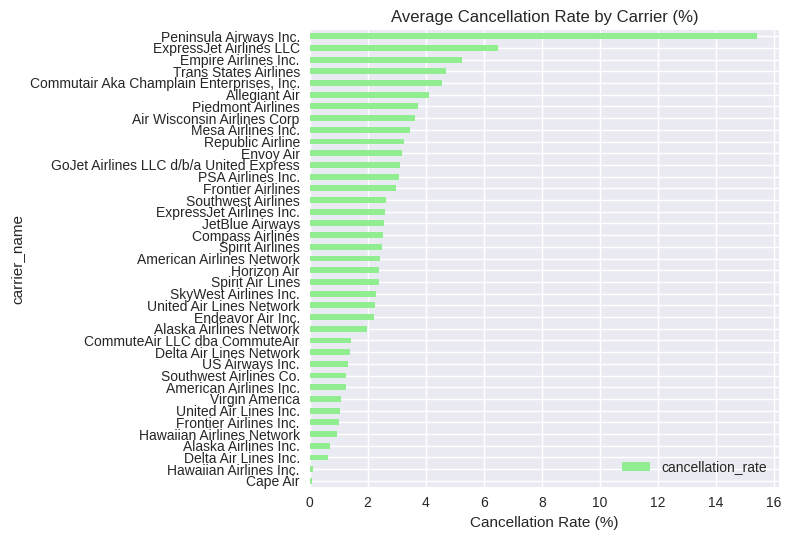

In [ ]:
plt.figure(figsize=(10, 6))
carrier_summary.sort_values('cancellation_rate', ascending=True).plot(
    y='cancellation_rate', kind='barh', color='lightgreen'
)
plt.title('Average Cancellation Rate by Carrier (%)')
plt.xlabel('Cancellation Rate (%)')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

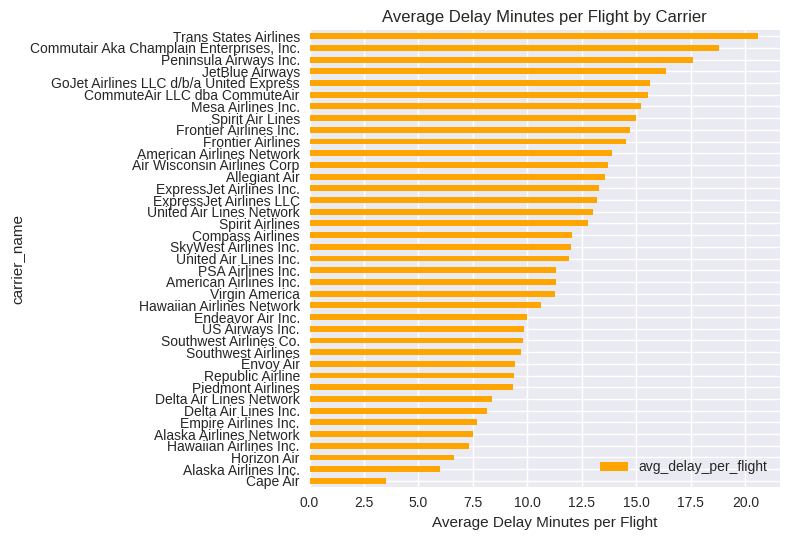

In [ ]:
plt.figure(figsize=(10, 6))
carrier_summary.sort_values('avg_delay_per_flight', ascending=True).plot(
    y='avg_delay_per_flight', kind='barh', color='orange'
)
plt.title('Average Delay Minutes per Flight by Carrier')
plt.xlabel('Average Delay Minutes per Flight')
plt.tight_layout()
plt.show()

In [ ]:
def delay_cause_analysis(df):
    """Analyze delay causes and their impact"""

    print("\n" + "="*60)
    print("DELAY CAUSE ANALYSIS")
    print("="*60)

    cause_counts = ['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']
    cause_delays = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']


    df['total_delay_causes'] = df[cause_counts].sum(axis=1)

    for cause in cause_counts:
        prop_col = f'{cause}_proportion'
        df[prop_col] = (df[cause] / df['total_delay_causes']) * 100
        df[prop_col] = df[prop_col].fillna(0)

    print("\n--- OVERALL DELAY CAUSE DISTRIBUTION ---")
    cause_summary = pd.DataFrame({
        'Cause': ['Carrier', 'Weather', 'NAS', 'Security', 'Late Aircraft'],
        'Total_Count': [df[col].sum() for col in cause_counts],
        'Total_Minutes': [df[col].sum() for col in cause_delays],
        'Avg_Minutes_Per_Incident': [
            df[cause_delays[i]].sum() / df[cause_counts[i]].sum()
            if df[cause_counts[i]].sum() > 0 else 0
            for i in range(len(cause_counts))
        ]
    })

    cause_summary['Percentage_of_Incidents'] = (cause_summary['Total_Count'] / cause_summary['Total_Count'].sum()) * 100
    cause_summary['Percentage_of_Minutes'] = (cause_summary['Total_Minutes'] / cause_summary['Total_Minutes'].sum()) * 100

    print(cause_summary.round(2))

    print("\n--- DELAY CAUSES BY CARRIER ---")
    carrier_causes = df.groupby('carrier_name')[cause_counts + cause_delays].sum()

    for i, cause in enumerate(cause_counts):
        carrier_causes[f'{cause}_avg_duration'] = carrier_causes[cause_delays[i]] / carrier_causes[cause]
        carrier_causes[f'{cause}_avg_duration'] = carrier_causes[f'{cause}_avg_duration'].fillna(0)

    print(carrier_causes.round(2))



    return cause_summary, carrier_causes

cause_summary, carrier_causes = delay_cause_analysis(df)


DELAY CAUSE ANALYSIS

--- OVERALL DELAY CAUSE DISTRIBUTION ---
           Cause  Total_Count  Total_Minutes  Avg_Minutes_Per_Incident  Percentage_of_Incidents  Percentage_of_Minutes
0        Carrier   3324447.29    237268793.0                     71.37                    31.68                  34.31
1        Weather    364391.74     37430676.0                    102.72                     3.47                   5.41
2            NAS   3059941.04    146768462.0                     47.96                    29.16                  21.22
3       Security     26009.57      1224329.0                     47.07                     0.25                   0.18
4  Late Aircraft   3719285.11    268827517.0                     72.28                    35.44                  38.87

--- DELAY CAUSES BY CARRIER ---
                                           carrier_ct  weather_ct     nas_ct  security_ct  late_aircraft_ct  carrier_delay  weather_delay   nas_delay  security_delay  late_aircraft_delay  c

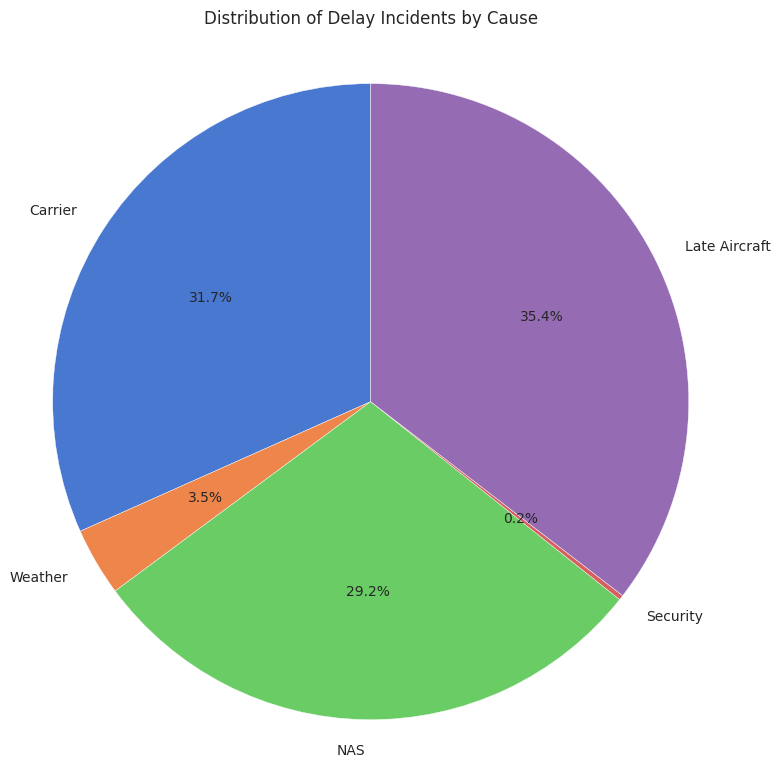

In [ ]:
plt.figure(figsize=(8, 8))
cause_summary.set_index('Cause')['Percentage_of_Incidents'].plot(
    kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette('muted')
)
plt.title('Distribution of Delay Incidents by Cause')
plt.ylabel('')
plt.axis('equal')
plt.tight_layout()
plt.show()

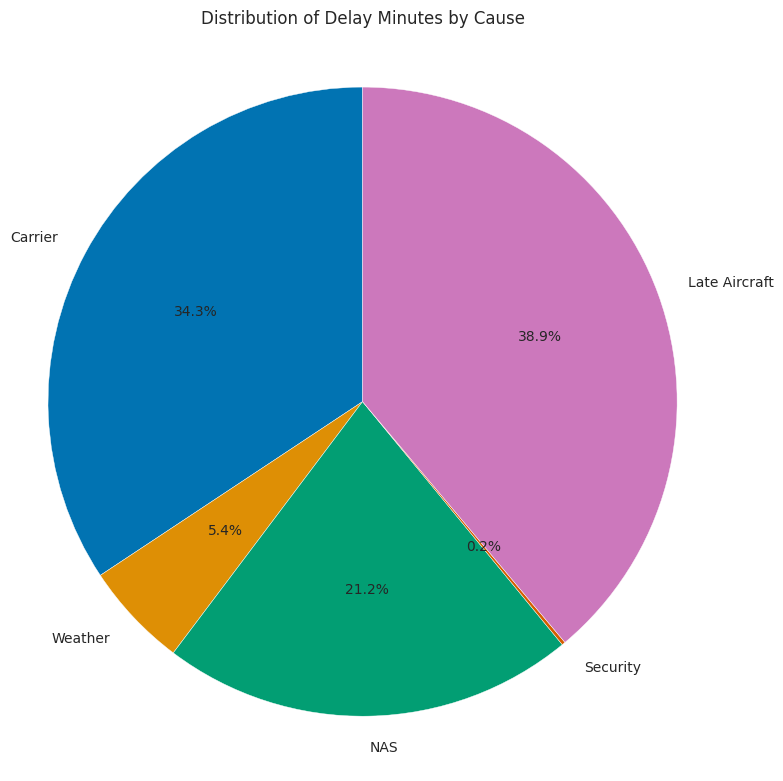

In [ ]:

plt.figure(figsize=(8, 8))
cause_summary.set_index('Cause')['Percentage_of_Minutes'].plot(
    kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette('colorblind')
)
plt.title('Distribution of Delay Minutes by Cause')
plt.ylabel('')
plt.axis('equal')
plt.tight_layout()
plt.show()

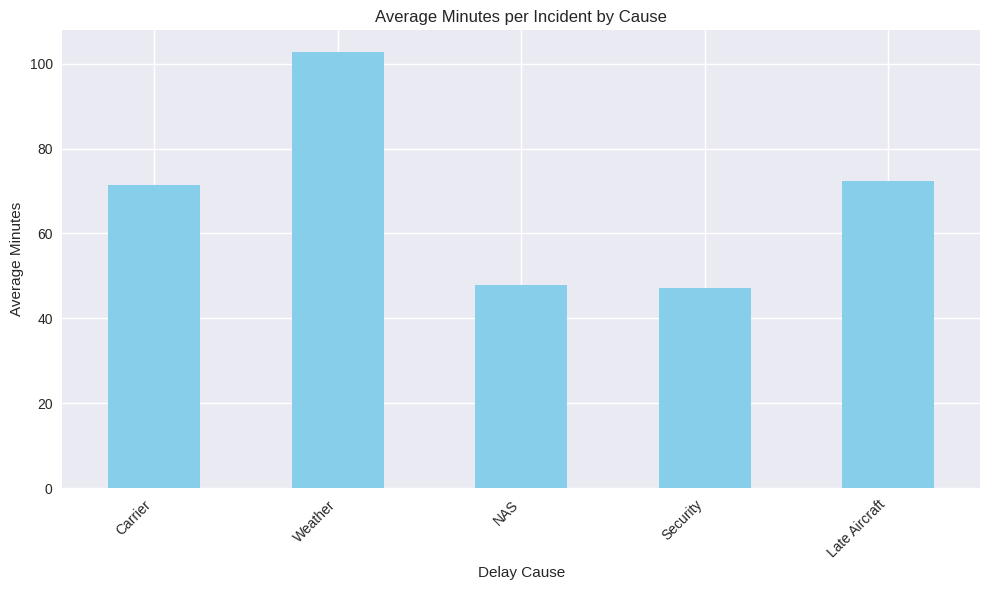

In [ ]:
plt.figure(figsize=(10, 6))
cause_summary.set_index('Cause')['Avg_Minutes_Per_Incident'].plot(
    kind='bar', color='skyblue'
)
plt.title('Average Minutes per Incident by Cause')
plt.xlabel('Delay Cause')
plt.ylabel('Average Minutes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

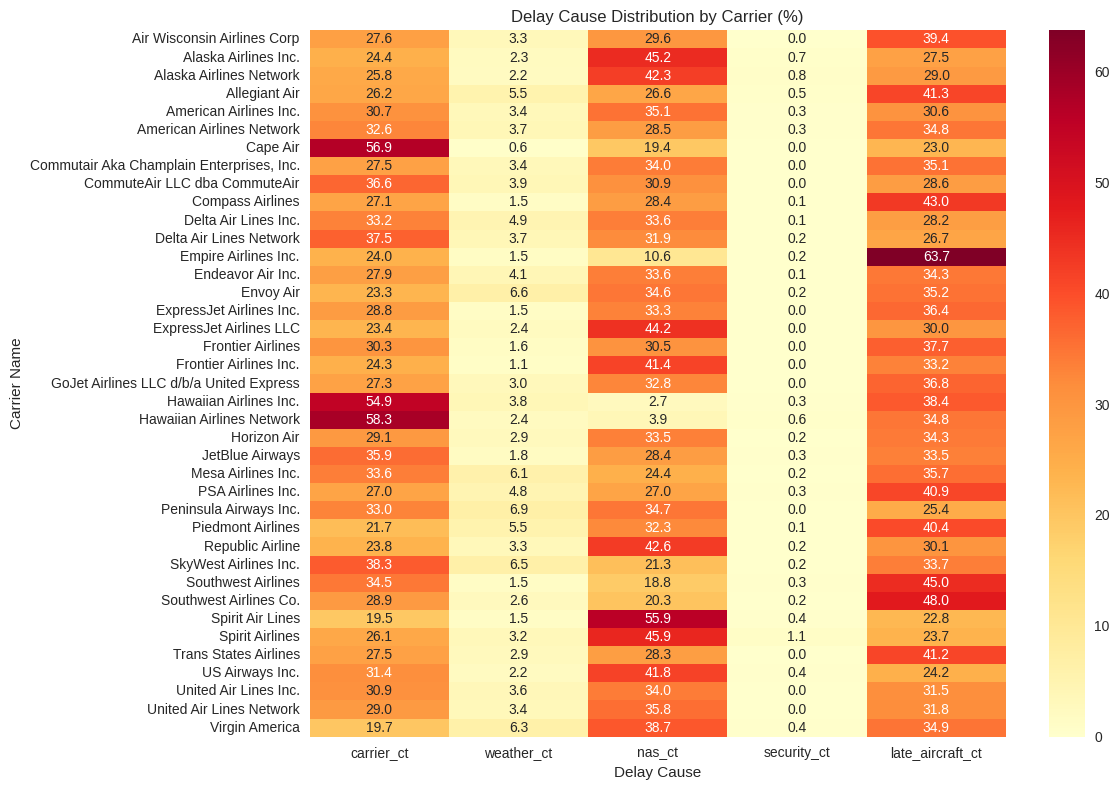

In [ ]:
plt.figure(figsize=(12, 8))
cause_counts = ['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']
cause_props = carrier_causes[cause_counts].div(carrier_causes[cause_counts].sum(axis=1), axis=0) * 100

sns.heatmap(cause_props, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Delay Cause Distribution by Carrier (%)')
plt.xlabel('Delay Cause')
plt.ylabel('Carrier Name')
plt.tight_layout()
plt.show()

In [ ]:
def carrier_performance_analysis(df):
    """Detailed carrier performance evaluation"""

    print("\n" + "="*60)
    print("CARRIER PERFORMANCE ANALYSIS")
    print("="*60)

    carrier_metrics = df.groupby('carrier_name').agg({
        'arr_flights': 'sum',
        'arr_del15': 'sum',
        'arr_delay': 'sum',
        'arr_cancelled': 'sum',
        'weather_ct': 'sum',
        'weather_delay': 'sum',
        'carrier_ct': 'sum',
        'carrier_delay': 'sum',
        'nas_ct': 'sum',
        'nas_delay': 'sum',
        'late_aircraft_ct': 'sum',
        'late_aircraft_delay': 'sum'
    })


    carrier_metrics['delay_rate'] = (carrier_metrics['arr_del15'] / carrier_metrics['arr_flights']) * 100
    carrier_metrics['avg_delay_per_flight'] = carrier_metrics['arr_delay'] / carrier_metrics['arr_flights']
    carrier_metrics['cancellation_rate'] = (carrier_metrics['arr_cancelled'] / carrier_metrics['arr_flights']) * 100
    carrier_metrics['weather_sensitivity'] = (carrier_metrics['weather_ct'] / carrier_metrics['arr_del15']) * 100
    carrier_metrics['operational_delays'] = (carrier_metrics['carrier_ct'] / carrier_metrics['arr_del15']) * 100

    carrier_metrics = carrier_metrics.fillna(0)

    print("\n--- CARRIER PERFORMANCE RANKINGS ---")

    print("\nRanking by Delay Rate (Lower is Better):")
    delay_ranking = carrier_metrics.sort_values('delay_rate')[['delay_rate', 'arr_flights', 'arr_del15']]
    print(delay_ranking.round(2))

    print("\nRanking by Average Delay Minutes per Flight (Lower is Better):")
    avg_delay_ranking = carrier_metrics.sort_values('avg_delay_per_flight')[['avg_delay_per_flight', 'arr_delay', 'arr_flights']]
    print(avg_delay_ranking.round(2))

    print("\nWeather Sensitivity Analysis (% of delays due to weather):")
    weather_sensitivity = carrier_metrics.sort_values('weather_sensitivity', ascending=False)[['weather_sensitivity', 'weather_ct', 'arr_del15']]
    print(weather_sensitivity.round(2))

    print("\n--- ROUTE-SPECIFIC PERFORMANCE ---")
    route_performance = df.groupby(['carrier_name', 'airport_name']).agg({
        'arr_flights': 'sum',
        'arr_del15': 'sum',
        'arr_delay': 'sum'
    }).reset_index()

    route_performance['delay_rate'] = (route_performance['arr_del15'] / route_performance['arr_flights']) * 100
    route_performance['avg_delay_per_flight'] = route_performance['arr_delay'] / route_performance['arr_flights']
    route_performance = route_performance.fillna(0)

    print("\nBest Route Performance (Top 10 by delay rate):")
    best_routes = route_performance.nsmallest(10, 'delay_rate')[['carrier_name', 'airport_name', 'delay_rate', 'arr_flights']]
    print(best_routes.round(2))

    print("\nWorst Route Performance (Top 10 by delay rate):")
    worst_routes = route_performance.nlargest(10, 'delay_rate')[['carrier_name', 'airport_name', 'delay_rate', 'arr_flights']]
    print(worst_routes.round(2))

    return carrier_metrics, route_performance

carrier_metrics, route_performance = carrier_performance_analysis(df)


CARRIER PERFORMANCE ANALYSIS

--- CARRIER PERFORMANCE RANKINGS ---

Ranking by Delay Rate (Lower is Better):
                                           delay_rate  arr_flights  arr_del15
carrier_name                                                                 
Cape Air                                         8.91       1661.0      148.0
Hawaiian Airlines Inc.                          10.46     233233.0    24399.0
Delta Air Lines Inc.                            13.26    2722187.0   361056.0
Endeavor Air Inc.                               13.49    1415179.0   190865.0
Delta Air Lines Network                         13.76    5148525.0   708404.0
Alaska Airlines Inc.                            13.80     534869.0    73824.0
Horizon Air                                     14.06     600159.0    84387.0
Empire Airlines Inc.                            14.80      23122.0     3423.0
Hawaiian Airlines Network                       14.92     416162.0    62102.0
Piedmont Airlines               

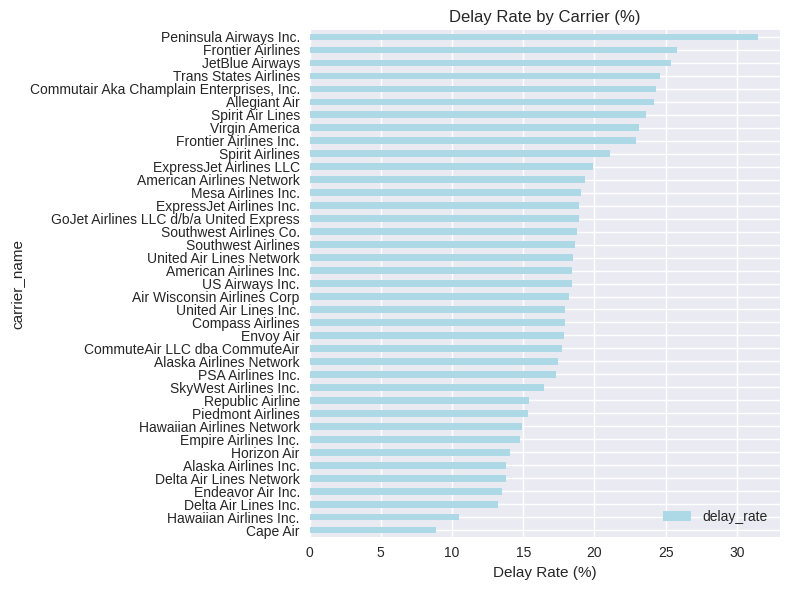

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
carrier_metrics.sort_values('delay_rate').plot(
    y='delay_rate', kind='barh', ax=ax, color='lightblue'
)
ax.set_title('Delay Rate by Carrier (%)')
ax.set_xlabel('Delay Rate (%)')
plt.tight_layout()
plt.show()


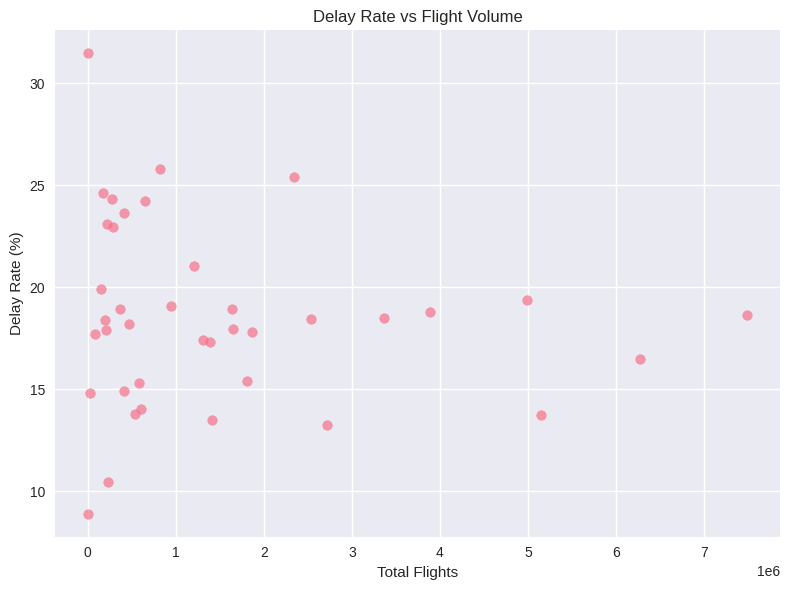

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(carrier_metrics['arr_flights'], carrier_metrics['delay_rate'], alpha=0.7)
ax.set_xlabel('Total Flights')
ax.set_ylabel('Delay Rate (%)')
ax.set_title('Delay Rate vs Flight Volume')
plt.tight_layout()
plt.show()


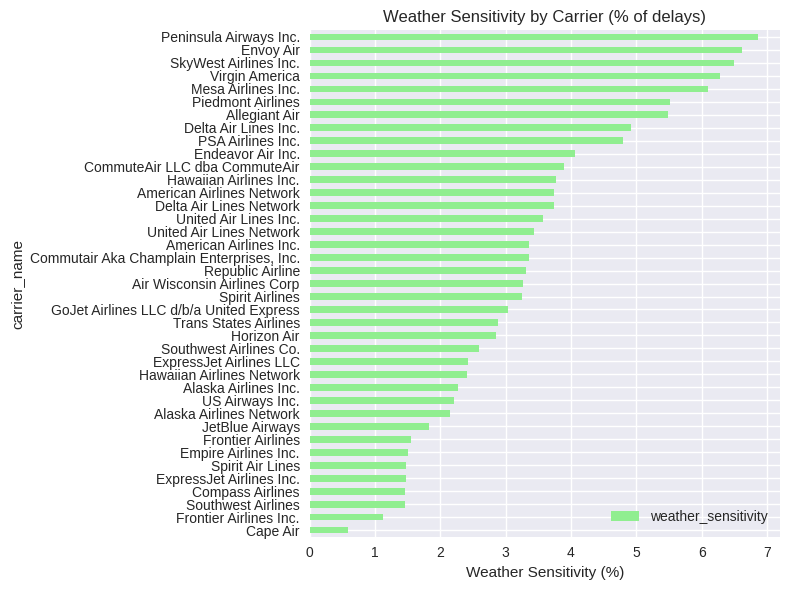

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
carrier_metrics.sort_values('weather_sensitivity').plot(
    y='weather_sensitivity', kind='barh', ax=ax, color='lightgreen'
)
ax.set_title('Weather Sensitivity by Carrier (% of delays)')
ax.set_xlabel('Weather Sensitivity (%)')
plt.tight_layout()
plt.show()


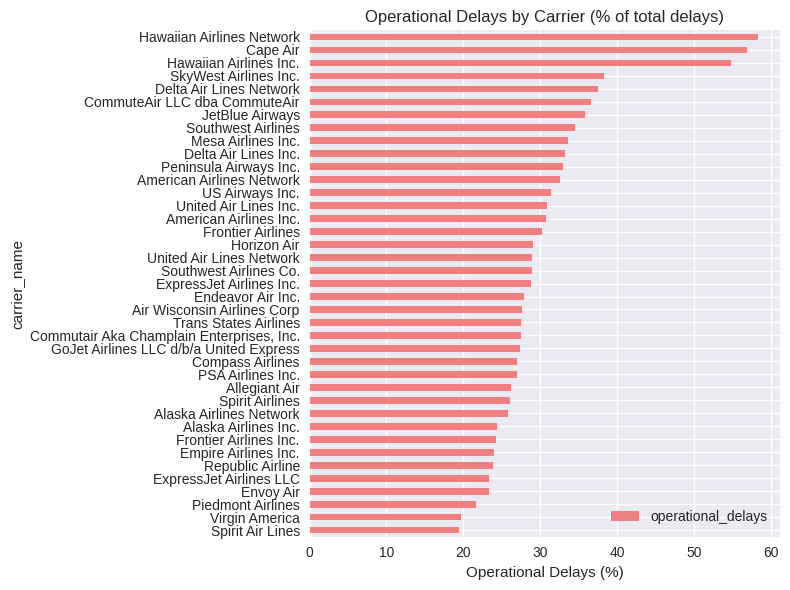

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
carrier_metrics.sort_values('operational_delays').plot(
    y='operational_delays', kind='barh', ax=ax, color='lightcoral'
)
ax.set_title('Operational Delays by Carrier (% of total delays)')
ax.set_xlabel('Operational Delays (%)')
plt.tight_layout()
plt.show()


In [ ]:
def airport_performance_analysis(df):
    """Analyze airport operational performance"""

    print("\n" + "="*60)
    print("AIRPORT PERFORMANCE ANALYSIS")
    print("="*60)


    airport_metrics = df.groupby(['airport', 'airport_name']).agg({
        'arr_flights': 'sum',
        'arr_del15': 'sum',
        'arr_delay': 'sum',
        'arr_cancelled': 'sum',
        'arr_diverted': 'sum',
        'weather_ct': 'sum',
        'weather_delay': 'sum',
        'nas_ct': 'sum',
        'nas_delay': 'sum',
        'carrier_ct': 'sum',
        'carrier_delay': 'sum'
    }).reset_index()

    airport_metrics['delay_rate'] = (airport_metrics['arr_del15'] / airport_metrics['arr_flights']) * 100
    airport_metrics['avg_delay_per_flight'] = airport_metrics['arr_delay'] / airport_metrics['arr_flights']
    airport_metrics['cancellation_rate'] = (airport_metrics['arr_cancelled'] / airport_metrics['arr_flights']) * 100
    airport_metrics['diversion_rate'] = (airport_metrics['arr_diverted'] / airport_metrics['arr_flights']) * 100
    airport_metrics['weather_impact'] = (airport_metrics['weather_delay'] / airport_metrics['arr_delay']) * 100
    airport_metrics['nas_impact'] = (airport_metrics['nas_delay'] / airport_metrics['arr_delay']) * 100

    airport_metrics = airport_metrics.fillna(0)

    print("\n--- AIRPORT PERFORMANCE RANKINGS ---")

    print("\nTop 15 Airports by Total Delay Minutes:")
    delay_hotspots = airport_metrics.nlargest(15, 'arr_delay')[['airport', 'airport_name', 'arr_delay', 'delay_rate', 'arr_flights']]
    print(delay_hotspots.round(2))

    print("\nTop 15 Airports by Delay Rate:")
    delay_rate_worst = airport_metrics.nlargest(15, 'delay_rate')[['airport', 'airport_name', 'delay_rate', 'arr_delay', 'arr_flights']]
    print(delay_rate_worst.round(2))


    print("\nTop 15 Airports by Cancellation Rate:")
    cancellation_worst = airport_metrics.nlargest(15, 'cancellation_rate')[['airport', 'airport_name', 'cancellation_rate', 'arr_cancelled', 'arr_flights']]
    print(cancellation_worst.round(2))


    airport_metrics['airport_type'] = pd.cut(
        airport_metrics['arr_flights'],
        bins=[0, 100, 500, float('inf')],
        labels=['Small', 'Medium', 'Large']
    )

    print("\n--- HUB VS REGIONAL ANALYSIS ---")
    hub_analysis = airport_metrics.groupby('airport_type').agg({
        'delay_rate': 'mean',
        'cancellation_rate': 'mean',
        'avg_delay_per_flight': 'mean',
        'weather_impact': 'mean',
        'nas_impact': 'mean',
        'arr_flights': 'sum'
    }).round(2)

    print(hub_analysis)

    print("\n--- AIRPORT OPERATIONAL PATTERNS ---")


    weather_dominant = airport_metrics.nlargest(10, 'weather_impact')[['airport', 'airport_name', 'weather_impact', 'weather_delay']]
    print("\nTop 10 Weather-Impacted Airports:")
    print(weather_dominant.round(2))

    nas_dominant = airport_metrics.nlargest(10, 'nas_impact')[['airport', 'airport_name', 'nas_impact', 'nas_delay']]
    print("\nTop 10 NAS-Impacted Airports:")
    print(nas_dominant.round(2))



    return airport_metrics, hub_analysis

airport_metrics, hub_analysis = airport_performance_analysis(df)



AIRPORT PERFORMANCE ANALYSIS

--- AIRPORT PERFORMANCE RANKINGS ---

Top 15 Airports by Total Delay Minutes:
    airport                                       airport_name   arr_delay  delay_rate  arr_flights
286     ORD          Chicago, IL: Chicago O'Hare International  39448875.0       18.26    2717844.0
106     DFW  Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...  32888526.0       18.33    2296203.0
23      ATL  Atlanta, GA: Hartsfield-Jackson Atlanta Intern...  30635991.0       13.78    3138514.0
105     DEN                   Denver, CO: Denver International  26849735.0       17.60    2268081.0
132     EWR           Newark, NJ: Newark Liberty International  21634922.0       24.76    1143744.0
217     LAX         Los Angeles, CA: Los Angeles International  21407538.0       19.22    1834232.0
360     SFO     San Francisco, CA: San Francisco International  20405356.0       22.12    1326489.0
226     LGA                            New York, NY: LaGuardia  18129309.0       21.81    1

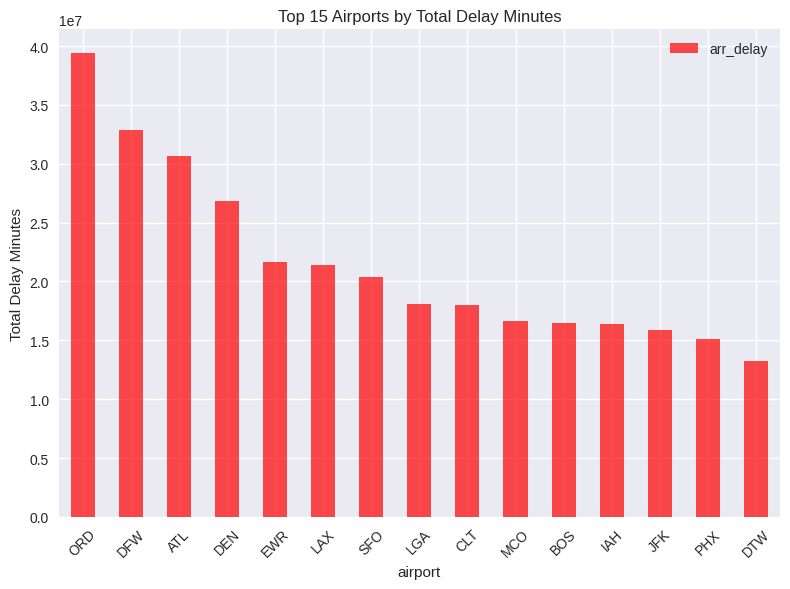

In [ ]:

fig, ax = plt.subplots(figsize=(8, 6))
top_delay_airports = airport_metrics.nlargest(15, 'arr_delay')
top_delay_airports.plot(
    x='airport', y='arr_delay', kind='bar', ax=ax, color='red', alpha=0.7
)
ax.set_title('Top 15 Airports by Total Delay Minutes')
ax.set_ylabel('Total Delay Minutes')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


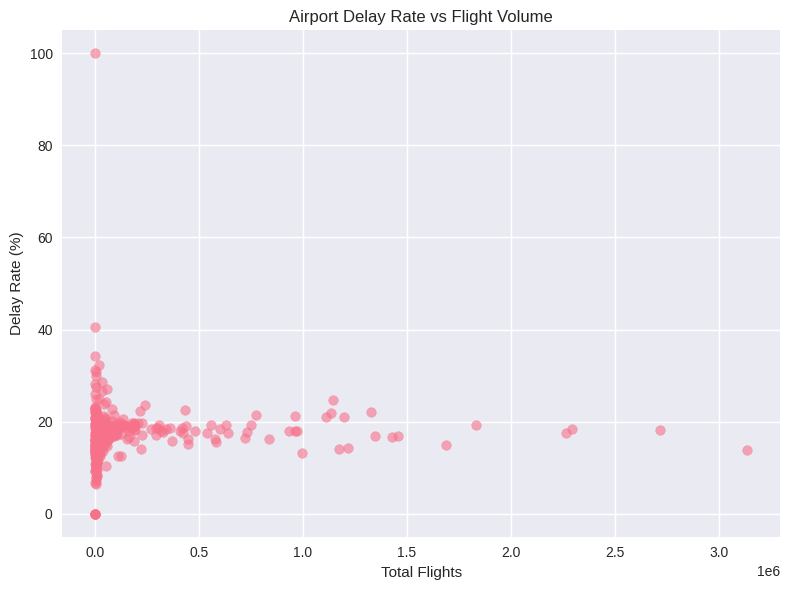

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(airport_metrics['arr_flights'], airport_metrics['delay_rate'], alpha=0.6)
ax.set_xlabel('Total Flights')
ax.set_ylabel('Delay Rate (%)')
ax.set_title('Airport Delay Rate vs Flight Volume')
plt.tight_layout()
plt.show()


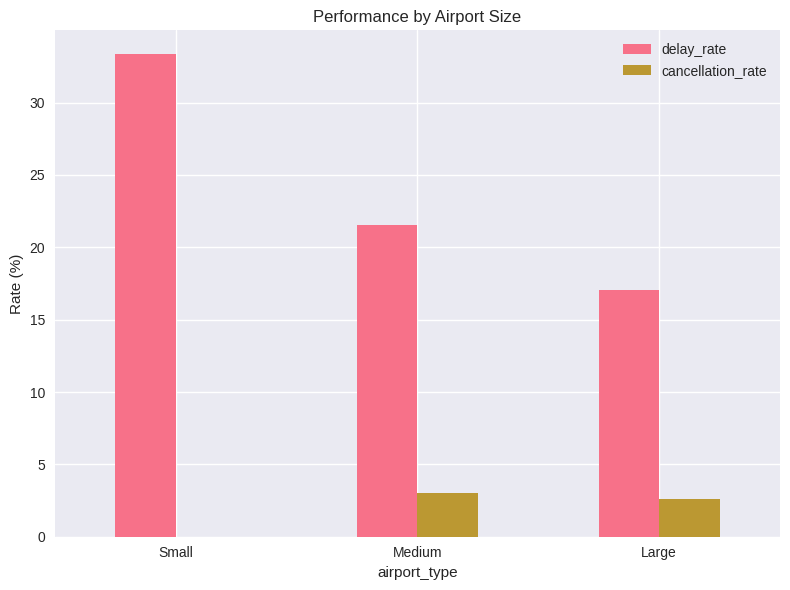

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
hub_analysis[['delay_rate', 'cancellation_rate']].plot(
    kind='bar', ax=ax
)
ax.set_title('Performance by Airport Size')
ax.set_ylabel('Rate (%)')
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()


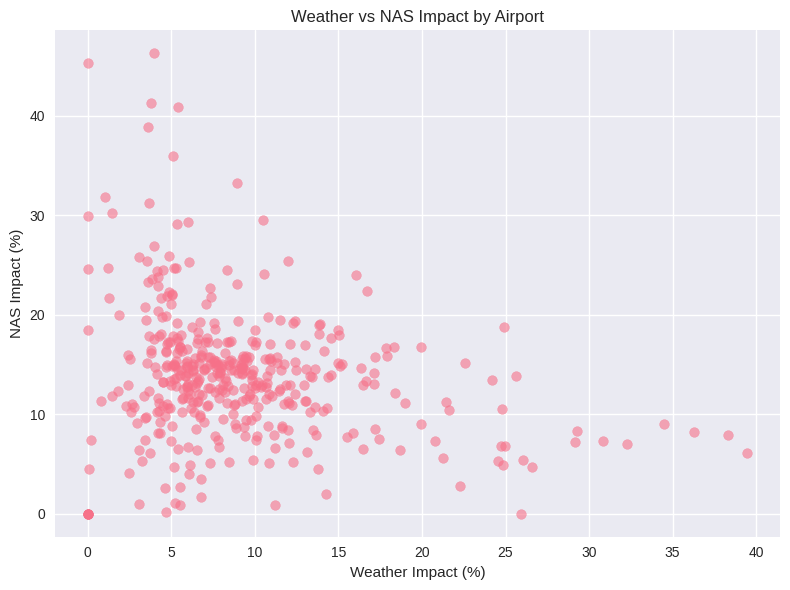

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(airport_metrics['weather_impact'], airport_metrics['nas_impact'], alpha=0.6)
ax.set_xlabel('Weather Impact (%)')
ax.set_ylabel('NAS Impact (%)')
ax.set_title('Weather vs NAS Impact by Airport')
plt.tight_layout()
plt.show()


In [ ]:
def weather_impact_analysis(df):
    """Analyze weather-related delays and patterns"""

    print("\n" + "="*60)
    print("WEATHER IMPACT ANALYSIS")
    print("="*60)

    weather_analysis = df.groupby(['airport', 'airport_name']).agg({
        'arr_flights': 'sum',
        'arr_del15': 'sum',
        'arr_cancelled': 'sum',
        'weather_ct': 'sum',
        'weather_delay': 'sum'
    }).reset_index()


    weather_analysis['weather_delay_rate'] = (weather_analysis['weather_ct'] / weather_analysis['arr_flights']) * 100
    weather_analysis['weather_cancellation_correlation'] = weather_analysis['weather_ct'] / (weather_analysis['arr_cancelled'] + 1)
    weather_analysis['avg_weather_delay_per_incident'] = weather_analysis['weather_delay'] / (weather_analysis['weather_ct'] + 1)
    weather_analysis['weather_proportion_of_delays'] = (weather_analysis['weather_ct'] / weather_analysis['arr_del15']) * 100

    weather_analysis = weather_analysis.fillna(0)

    print("\n--- WEATHER-DOMINANT AIRPORTS ---")
    weather_dominant = weather_analysis.nlargest(15, 'weather_ct')[
        ['airport', 'airport_name', 'weather_ct', 'weather_delay', 'weather_delay_rate', 'avg_weather_delay_per_incident']
    ]
    print(weather_dominant.round(2))

    print("\n--- AIRPORTS WITH HIGHEST WEATHER DELAY RATES ---")
    weather_rate_high = weather_analysis.nlargest(15, 'weather_delay_rate')[
        ['airport', 'airport_name', 'weather_delay_rate', 'weather_ct', 'arr_flights']
    ]
    print(weather_rate_high.round(2))


    print("\n--- WEATHER DELAYS VS CANCELLATIONS CORRELATION ---")
    correlation_data = df[df['weather_ct'] > 0].copy()

    if len(correlation_data) > 0:
        corr_coef, p_value = pearsonr(correlation_data['weather_ct'], correlation_data['arr_cancelled'])
        print(f"Correlation coefficient: {corr_coef:.3f}")
        print(f"P-value: {p_value:.3f}")

        if p_value < 0.05:
            print("Statistically significant correlation found!")
        else:
            print("No statistically significant correlation found.")

    print("\n--- WEATHER IMPACT BY CARRIER ---")
    carrier_weather = df.groupby('carrier_name').agg({
        'arr_flights': 'sum',
        'weather_ct': 'sum',
        'weather_delay': 'sum'
    })

    carrier_weather['weather_delay_rate'] = (carrier_weather['weather_ct'] / carrier_weather['arr_flights']) * 100
    carrier_weather['avg_weather_delay_per_incident'] = carrier_weather['weather_delay'] / (carrier_weather['weather_ct'] + 1)
    carrier_weather = carrier_weather.fillna(0)

    print(carrier_weather.round(2))

    if df['month'].nunique() > 1:
        print("\n--- SEASONAL WEATHER PATTERNS ---")
        seasonal_weather = df.groupby('month').agg({
            'weather_ct': 'sum',
            'weather_delay': 'sum',
            'arr_flights': 'sum'
        })
        seasonal_weather['weather_delay_rate'] = (seasonal_weather['weather_ct'] / seasonal_weather['arr_flights']) * 100
        print(seasonal_weather.round(2))


    return weather_analysis, carrier_weather , correlation_data

weather_analysis, carrier_weather,correlation_data = weather_impact_analysis(df)



WEATHER IMPACT ANALYSIS

--- WEATHER-DOMINANT AIRPORTS ---
    airport                                       airport_name  weather_ct  weather_delay  weather_delay_rate  avg_weather_delay_per_incident
106     DFW  Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...    20017.52      2211556.0                0.87                          110.48
286     ORD          Chicago, IL: Chicago O'Hare International    16878.16      2112350.0                0.62                          125.15
23      ATL  Atlanta, GA: Hartsfield-Jackson Atlanta Intern...    15654.84      1641757.0                0.50                          104.87
105     DEN                   Denver, CO: Denver International    13068.11      1346176.0                0.58                          103.00
217     LAX         Los Angeles, CA: Los Angeles International    10604.38       903969.0                0.58                           85.24
81      CLT     Charlotte, NC: Charlotte Douglas International     9957.76       993633.

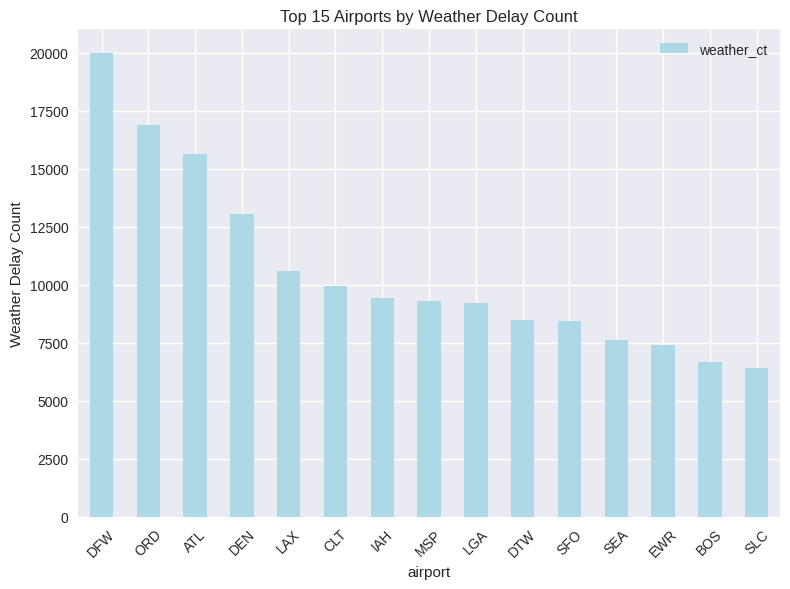

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
top_weather = weather_analysis.nlargest(15, 'weather_ct')
top_weather.plot(x='airport', y='weather_ct', kind='bar', ax=ax, color='lightblue')
ax.set_title('Top 15 Airports by Weather Delay Count')
ax.set_ylabel('Weather Delay Count')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


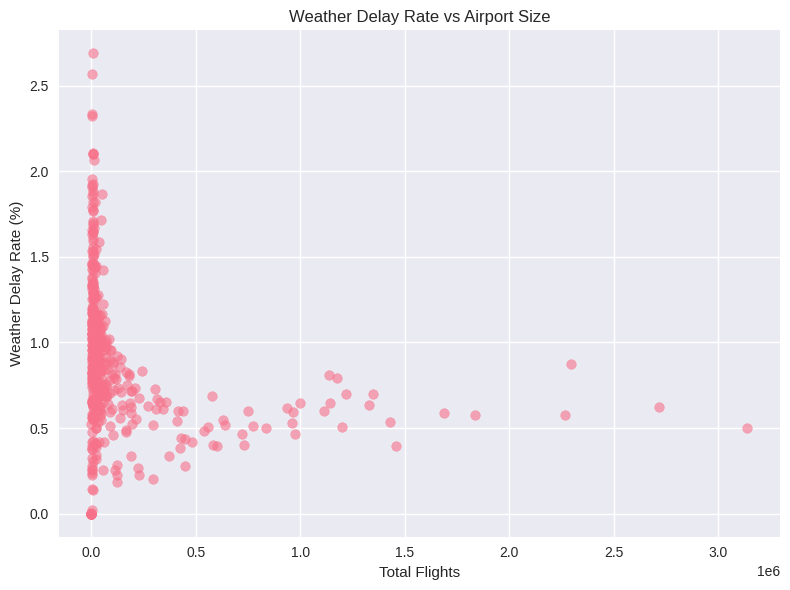

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(weather_analysis['arr_flights'], weather_analysis['weather_delay_rate'], alpha=0.6)
ax.set_xlabel('Total Flights')
ax.set_ylabel('Weather Delay Rate (%)')
ax.set_title('Weather Delay Rate vs Airport Size')
plt.tight_layout()
plt.show()


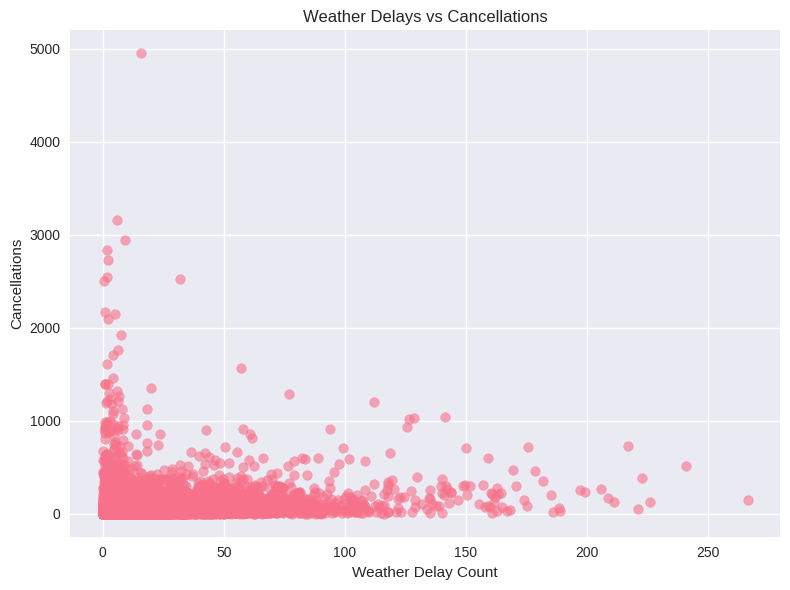

In [ ]:
if len(correlation_data) > 0:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(correlation_data['weather_ct'], correlation_data['arr_cancelled'], alpha=0.6)
    ax.set_xlabel('Weather Delay Count')
    ax.set_ylabel('Cancellations')
    ax.set_title('Weather Delays vs Cancellations')
    plt.tight_layout()
    plt.show()


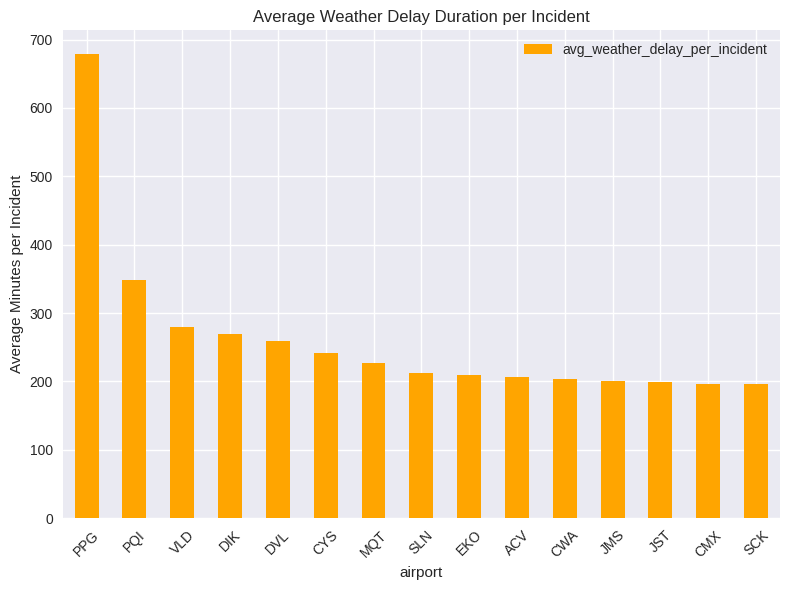

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
top_duration = weather_analysis.nlargest(15, 'avg_weather_delay_per_incident')
top_duration.plot(x='airport', y='avg_weather_delay_per_incident', kind='bar', ax=ax, color='orange')
ax.set_title('Average Weather Delay Duration per Incident')
ax.set_ylabel('Average Minutes per Incident')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
def operational_efficiency_analysis(df):
    """Analyze operational efficiency patterns"""

    print("\n" + "="*60)
    print("OPERATIONAL EFFICIENCY ANALYSIS")
    print("="*60)

    print("\n--- NAS DELAY ANALYSIS ---")
    nas_analysis = df.groupby(['airport', 'airport_name']).agg({
        'arr_flights': 'sum',
        'nas_ct': 'sum',
        'nas_delay': 'sum',
        'arr_del15': 'sum'
    }).reset_index()

    nas_analysis['nas_delay_rate'] = (nas_analysis['nas_ct'] / nas_analysis['arr_flights']) * 100
    nas_analysis['nas_proportion'] = (nas_analysis['nas_ct'] / nas_analysis['arr_del15']) * 100
    nas_analysis['avg_nas_delay_per_incident'] = nas_analysis['nas_delay'] / (nas_analysis['nas_ct'] + 1)
    nas_analysis = nas_analysis.fillna(0)

    print("Top 15 Airports by NAS Delay Count:")
    nas_top = nas_analysis.nlargest(15, 'nas_ct')[['airport', 'airport_name', 'nas_ct', 'nas_delay_rate', 'nas_proportion']]
    print(nas_top.round(2))

    print("\n--- LATE AIRCRAFT PROPAGATION ANALYSIS ---")
    late_aircraft_analysis = df.groupby(['airport', 'airport_name']).agg({
        'arr_flights': 'sum',
        'late_aircraft_ct': 'sum',
        'late_aircraft_delay': 'sum',
        'arr_del15': 'sum'
    }).reset_index()

    late_aircraft_analysis['late_aircraft_rate'] = (late_aircraft_analysis['late_aircraft_ct'] / late_aircraft_analysis['arr_flights']) * 100
    late_aircraft_analysis['late_aircraft_proportion'] = (late_aircraft_analysis['late_aircraft_ct'] / late_aircraft_analysis['arr_del15']) * 100
    late_aircraft_analysis['avg_late_aircraft_delay'] = late_aircraft_analysis['late_aircraft_delay'] / (late_aircraft_analysis['late_aircraft_ct'] + 1)
    late_aircraft_analysis = late_aircraft_analysis.fillna(0)

    print("Top 15 Airports by Late Aircraft Delay Count:")
    late_aircraft_top = late_aircraft_analysis.nlargest(15, 'late_aircraft_ct')[
        ['airport', 'airport_name', 'late_aircraft_ct', 'late_aircraft_rate', 'avg_late_aircraft_delay']
    ]
    print(late_aircraft_top.round(2))

    print("\n--- CARRIER OPERATIONAL EFFICIENCY ---")
    carrier_efficiency = df.groupby('carrier_name').agg({
        'arr_flights': 'sum',
        'carrier_ct': 'sum',
        'carrier_delay': 'sum',
        'late_aircraft_ct': 'sum',
        'late_aircraft_delay': 'sum',
        'nas_ct': 'sum',
        'nas_delay': 'sum'
    })


    carrier_efficiency['carrier_delay_rate'] = (carrier_efficiency['carrier_ct'] / carrier_efficiency['arr_flights']) * 100
    carrier_efficiency['late_aircraft_rate'] = (carrier_efficiency['late_aircraft_ct'] / carrier_efficiency['arr_flights']) * 100
    carrier_efficiency['nas_exposure'] = (carrier_efficiency['nas_ct'] / carrier_efficiency['arr_flights']) * 100
    carrier_efficiency['operational_control'] = (
        (carrier_efficiency['carrier_ct'] + carrier_efficiency['late_aircraft_ct']) /
        (carrier_efficiency['carrier_ct'] + carrier_efficiency['late_aircraft_ct'] + carrier_efficiency['nas_ct'] + 1)
    ) * 100

    carrier_efficiency = carrier_efficiency.fillna(0)
    print(carrier_efficiency.round(2))

    print("\n--- FLIGHT VOLUME IMPACT ON NAS DELAYS ---")
    volume_nas_corr = df[df['nas_ct'] > 0].copy()

    if len(volume_nas_corr) > 0:
        corr_coef, p_value = pearsonr(volume_nas_corr['arr_flights'], volume_nas_corr['nas_ct'])
        print(f"Correlation between flight volume and NAS delays: {corr_coef:.3f}")
        print(f"P-value: {p_value:.3f}")

        if p_value < 0.05:
            print("Statistically significant correlation found!")
        else:
            print("No statistically significant correlation found.")

    print("\n--- RECOVERY CAPABILITY ANALYSIS ---")
    recovery_analysis = df.copy()
    recovery_analysis['total_controllable_delays'] = recovery_analysis['carrier_ct'] + recovery_analysis['late_aircraft_ct']
    recovery_analysis['total_uncontrollable_delays'] = recovery_analysis['weather_ct'] + recovery_analysis['nas_ct'] + recovery_analysis['security_ct']
    recovery_analysis['recovery_ratio'] = recovery_analysis['total_uncontrollable_delays'] / (recovery_analysis['total_controllable_delays'] + 1)

    recovery_by_carrier = recovery_analysis.groupby('carrier_name').agg({
        'total_controllable_delays': 'sum',
        'total_uncontrollable_delays': 'sum',
        'recovery_ratio': 'mean'
    }).round(2)

    print("Recovery Capability by Carrier (Higher uncontrollable vs controllable ratio = better operational control):")
    print(recovery_by_carrier.sort_values('recovery_ratio', ascending=False))



    return nas_analysis, late_aircraft_analysis, carrier_efficiency,volume_nas_corr


nas_analysis, late_aircraft_analysis, carrier_efficiency,volume_nas_corr = operational_efficiency_analysis(df)



OPERATIONAL EFFICIENCY ANALYSIS

--- NAS DELAY ANALYSIS ---
Top 15 Airports by NAS Delay Count:
    airport                                       airport_name     nas_ct  nas_delay_rate  nas_proportion
286     ORD          Chicago, IL: Chicago O'Hare International  186634.58            6.87           37.60
132     EWR           Newark, NJ: Newark Liberty International  152269.14           13.31           53.77
106     DFW  Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...  130935.97            5.70           31.10
360     SFO     San Francisco, CA: San Francisco International  129909.56            9.79           44.27
23      ATL  Atlanta, GA: Hartsfield-Jackson Atlanta Intern...  127104.00            4.05           29.38
217     LAX         Los Angeles, CA: Los Angeles International  125704.76            6.85           35.65
105     DEN                   Denver, CO: Denver International  123482.05            5.44           30.94
226     LGA                            New York, NY: La

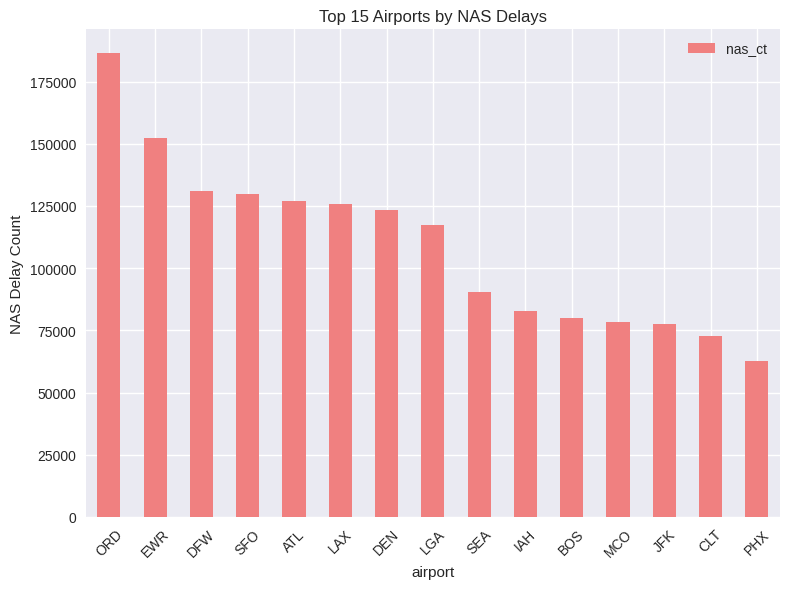

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
nas_top_viz = nas_analysis.nlargest(15, 'nas_ct')
nas_top_viz.plot(x='airport', y='nas_ct', kind='bar', ax=ax, color='lightcoral')
ax.set_title('Top 15 Airports by NAS Delays')
ax.set_ylabel('NAS Delay Count')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


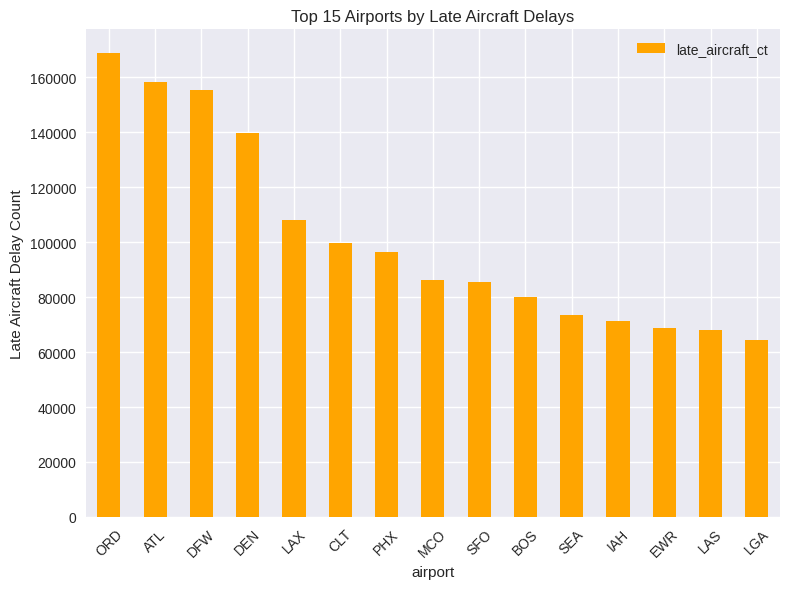

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
late_aircraft_top_viz = late_aircraft_analysis.nlargest(15, 'late_aircraft_ct')
late_aircraft_top_viz.plot(x='airport', y='late_aircraft_ct', kind='bar', ax=ax, color='orange')
ax.set_title('Top 15 Airports by Late Aircraft Delays')
ax.set_ylabel('Late Aircraft Delay Count')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


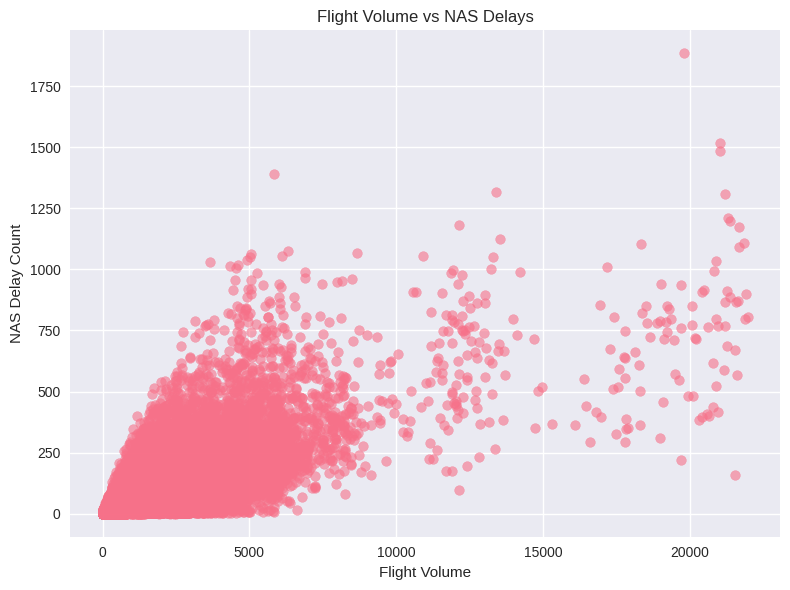

In [ ]:
if len(volume_nas_corr) > 0:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(volume_nas_corr['arr_flights'], volume_nas_corr['nas_ct'], alpha=0.6)
    ax.set_xlabel('Flight Volume')
    ax.set_ylabel('NAS Delay Count')
    ax.set_title('Flight Volume vs NAS Delays')
    plt.tight_layout()
    plt.show()


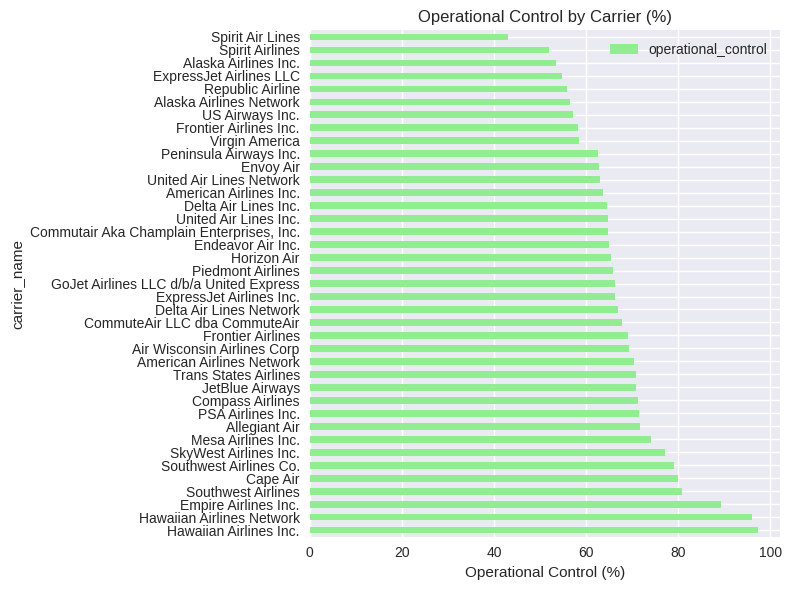

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
carrier_efficiency.sort_values('operational_control', ascending=False).plot(
    y='operational_control', kind='barh', ax=ax, color='lightgreen'
)
ax.set_title('Operational Control by Carrier (%)')
ax.set_xlabel('Operational Control (%)')
plt.tight_layout()
plt.show()


In [ ]:
def security_rare_events_analysis(df):
    """Analyze security delays and rare operational events"""

    print("\n" + "="*60)
    print("SECURITY & RARE EVENTS ANALYSIS")
    print("="*60)


    print("\n--- SECURITY DELAYS ANALYSIS ---")
    security_data = df[df['security_ct'] > 0].copy()

    if len(security_data) > 0:
        print(f"Total security delay incidents: {df['security_ct'].sum()}")
        print(f"Airports with security delays: {len(security_data)}")
        print(f"Total security delay minutes: {df['security_delay'].sum()}")

        security_summary = security_data.groupby(['airport', 'airport_name']).agg({
            'security_ct': 'sum',
            'security_delay': 'sum',
            'arr_flights': 'sum'
        }).reset_index()

        security_summary['avg_security_delay_per_incident'] = security_summary['security_delay'] / security_summary['security_ct']
        security_summary['security_delay_rate'] = (security_summary['security_ct'] / security_summary['arr_flights']) * 100

        print("\nAirports with Security Delays:")
        print(security_summary.round(2))


        carrier_security = security_data.groupby('carrier_name').agg({
            'security_ct': 'sum',
            'security_delay': 'sum',
            'arr_flights': 'sum'
        })
        carrier_security['security_delay_rate'] = (carrier_security['security_ct'] / carrier_security['arr_flights']) * 100
        print("\nSecurity Delays by Carrier:")
        print(carrier_security.round(2))
    else:
        print("No security delays found in the dataset.")

    print("\n--- OUTLIER DETECTION ---")

    def detect_outliers(series, factor=1.5):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        return (series < lower_bound) | (series > upper_bound)


    outlier_metrics = ['delay_rate', 'avg_delay_per_flight', 'cancellation_rate']


    if 'delay_rate' not in df.columns:
        df['delay_rate'] = (df['arr_del15'] / df['arr_flights']) * 100
        df['delay_rate'] = df['delay_rate'].fillna(0)

    if 'avg_delay_per_flight' not in df.columns:
        df['avg_delay_per_flight'] = df['arr_delay'] / df['arr_flights']
        df['avg_delay_per_flight'] = df['avg_delay_per_flight'].fillna(0)

    if 'cancellation_rate' not in df.columns:
        df['cancellation_rate'] = (df['arr_cancelled'] / df['arr_flights']) * 100
        df['cancellation_rate'] = df['cancellation_rate'].fillna(0)

    for metric in outlier_metrics:
        if metric in df.columns:
            outliers = detect_outliers(df[metric])
            outlier_data = df[outliers]

            print(f"\n{metric.upper()} OUTLIERS:")
            print(f"Number of outliers: {len(outlier_data)}")

            if len(outlier_data) > 0:
                print("Outlier entries:")
                outlier_summary = outlier_data[['carrier_name', 'airport_name', metric, 'arr_flights']].sort_values(metric, ascending=False)
                print(outlier_summary.head(10).round(2))

    print("\n--- EXTREME WEATHER EVENTS ---")
    extreme_weather = df[df['weather_delay'] > df['weather_delay'].quantile(0.95)]

    if len(extreme_weather) > 0:
        print("Extreme weather delay events (95th percentile and above):")
        extreme_weather_summary = extreme_weather[['carrier_name', 'airport_name', 'weather_ct', 'weather_delay', 'arr_flights']].sort_values('weather_delay', ascending=False)
        print(extreme_weather_summary.round(2))


    print("\n--- OPERATIONAL ANOMALIES ---")


    low_volume_high_delay = df[(df['arr_flights'] < df['arr_flights'].quantile(0.25)) &
                               (df['delay_rate'] > df['delay_rate'].quantile(0.75))]

    if len(low_volume_high_delay) > 0:
        print("Low Volume, High Delay Rate Anomalies:")
        print(low_volume_high_delay[['carrier_name', 'airport_name', 'arr_flights', 'delay_rate']].round(2))


    high_cancel_low_delay = df[(df['cancellation_rate'] > df['cancellation_rate'].quantile(0.75)) &
                               (df['delay_rate'] < df['delay_rate'].quantile(0.25))]

    if len(high_cancel_low_delay) > 0:
        print("\nHigh Cancellation, Low Delay Rate Anomalies:")
        print(high_cancel_low_delay[['carrier_name', 'airport_name', 'cancellation_rate', 'delay_rate']].round(2))



    return security_data, extreme_weather,security_summary,carrier_security

security_data, extreme_weather,security_summary,carrier_security = security_rare_events_analysis(df)



SECURITY & RARE EVENTS ANALYSIS

--- SECURITY DELAYS ANALYSIS ---
Total security delay incidents: 26009.570000000003
Airports with security delays: 20248
Total security delay minutes: 1224329.0

Airports with Security Delays:
    airport                                       airport_name  security_ct  security_delay  arr_flights  avg_security_delay_per_incident  security_delay_rate
0       ABE  Allentown/Bethlehem/Easton, PA: Lehigh Valley ...        11.04           820.0       1983.0                            74.28                 0.56
1       ABI                      Abilene, TX: Abilene Regional         7.85           293.0       1906.0                            37.32                 0.41
2       ABQ  Albuquerque, NM: Albuquerque International Sun...        82.82          3575.0      47713.0                            43.17                 0.17
3       ABY             Albany, GA: Southwest Georgia Regional         0.61            14.0         88.0                            22.95

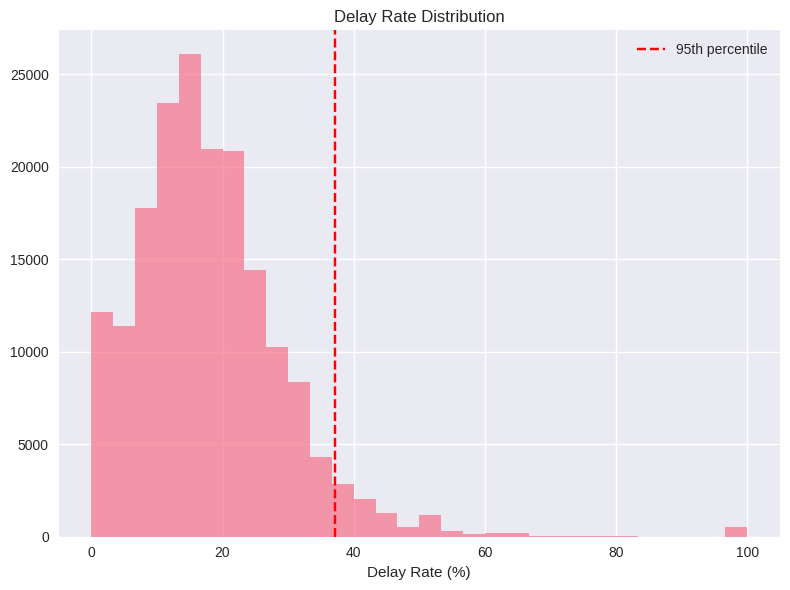

In [ ]:

fig, ax = plt.subplots(figsize=(8, 6))
df['delay_rate'].hist(bins=30, ax=ax, alpha=0.7)
ax.axvline(df['delay_rate'].quantile(0.95), color='red', linestyle='--', label='95th percentile')
ax.set_title('Delay Rate Distribution')
ax.set_xlabel('Delay Rate (%)')
ax.legend()
plt.tight_layout()
plt.show()


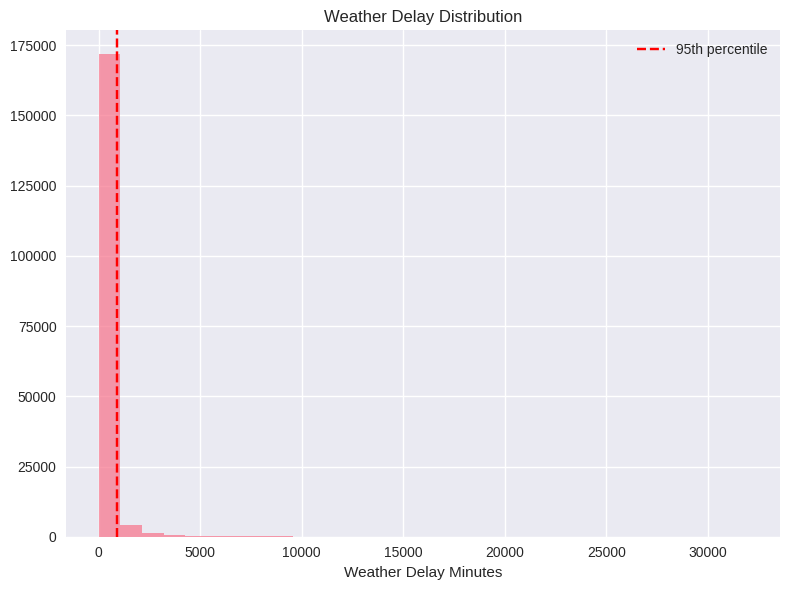

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
df['weather_delay'].hist(bins=30, ax=ax, alpha=0.7)
ax.axvline(df['weather_delay'].quantile(0.95), color='red', linestyle='--', label='95th percentile')
ax.set_title('Weather Delay Distribution')
ax.set_xlabel('Weather Delay Minutes')
ax.legend()
plt.tight_layout()
plt.show()


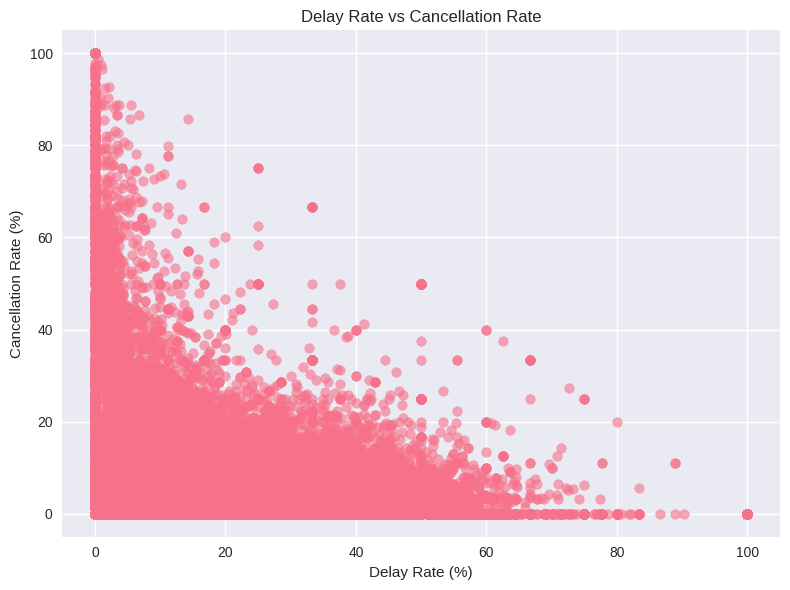

In [ ]:

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df['delay_rate'], df['cancellation_rate'], alpha=0.6)
ax.set_xlabel('Delay Rate (%)')
ax.set_ylabel('Cancellation Rate (%)')
ax.set_title('Delay Rate vs Cancellation Rate')
plt.tight_layout()
plt.show()


In [ ]:
def correlation_relationship_analysis(df):
    """Analyze correlations between different operational metrics"""

    print("\n" + "="*60)
    print("CORRELATION & RELATIONSHIP ANALYSIS")
    print("="*60)

    correlation_metrics = [
        'arr_flights', 'arr_del15', 'arr_delay', 'arr_cancelled', 'arr_diverted',
        'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
        'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'
    ]

    if 'delay_rate' not in df.columns:
        df['delay_rate'] = (df['arr_del15'] / df['arr_flights']) * 100
        df['delay_rate'] = df['delay_rate'].fillna(0)

    if 'cancellation_rate' not in df.columns:
        df['cancellation_rate'] = (df['arr_cancelled'] / df['arr_flights']) * 100
        df['cancellation_rate'] = df['cancellation_rate'].fillna(0)

    correlation_metrics.extend(['delay_rate', 'cancellation_rate'])
    available_metrics = [col for col in correlation_metrics if col in df.columns]

    print("\n--- CORRELATION MATRIX ---")
    correlation_matrix = df[available_metrics].corr()
    print("Correlation Matrix (top correlations):")

    correlations = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            correlations.append({
                'metric1': correlation_matrix.columns[i],
                'metric2': correlation_matrix.columns[j],
                'correlation': correlation_matrix.iloc[i, j]
            })

    correlations_df = pd.DataFrame(correlations)
    correlations_df = correlations_df.sort_values('correlation', key=abs, ascending=False)

    print("\nStrongest Positive Correlations:")
    strong_positive = correlations_df[correlations_df['correlation'] > 0.7].head(10)
    print(strong_positive.round(3))

    print("\nStrongest Negative Correlations:")
    strong_negative = correlations_df[correlations_df['correlation'] < -0.5].head(10)
    print(strong_negative.round(3))


In [ ]:
correlation_relationship_analysis(df)


CORRELATION & RELATIONSHIP ANALYSIS

--- CORRELATION MATRIX ---
Correlation Matrix (top correlations):

Strongest Positive Correlations:
              metric1              metric2  correlation
16          arr_del15            arr_delay        0.967
42          arr_delay  late_aircraft_delay        0.965
23          arr_del15     late_aircraft_ct        0.964
112  late_aircraft_ct  late_aircraft_delay        0.963
95             nas_ct            nas_delay        0.947
28          arr_del15  late_aircraft_delay        0.947
38          arr_delay        carrier_delay        0.944
19          arr_del15           carrier_ct        0.943
74         carrier_ct        carrier_delay        0.937
85         weather_ct        weather_delay        0.929

Strongest Negative Correlations:
Empty DataFrame
Columns: [metric1, metric2, correlation]
Index: []


In [ ]:
    print("\n--- SPECIFIC RELATIONSHIP ANALYSES ---")
    print("\n1. Flight Volume Impact Analysis:")
    volume_relationships = {}
    delay_types = ['carrier_ct', 'weather_ct', 'nas_ct', 'late_aircraft_ct']

    for delay_type in delay_types:
        if delay_type in df.columns:

            subset_for_corr = df[['arr_flights', delay_type]].dropna()


            if len(subset_for_corr) > 1:
                corr_coef, p_value = pearsonr(subset_for_corr['arr_flights'], subset_for_corr[delay_type])
                volume_relationships[delay_type] = {
                    'correlation': corr_coef,
                    'p_value': p_value,
                    'significant': p_value < 0.05
                }
            else:
                 volume_relationships[delay_type] = {
                    'correlation': float('nan'),
                    'p_value': float('nan'),
                    'significant': False
                 }
                 print(f"Warning: Not enough data points without NaNs to calculate correlation for arr_flights and {delay_type}.")


    volume_df = pd.DataFrame(volume_relationships).T
    print(volume_df.round(3))

    print("\n2. Delay Cause Interconnections:")

    delay_types_subset = df[delay_types].dropna()
    if len(delay_types_subset) > 1:
        delay_cause_matrix = delay_types_subset.corr()
        print(delay_cause_matrix.round(3))
    else:
        print("Warning: Not enough data points without NaNs to calculate the Delay Cause Interconnections matrix.")


    print("\n3. Delays vs Cancellations Analysis:")
    delay_cancel_relationships = {}
    for delay_type in delay_types:
        if delay_type in df.columns:

            subset_for_corr = df[[delay_type, 'arr_cancelled']].dropna()


            subset = subset_for_corr[(subset_for_corr[delay_type] > 0) & (subset_for_corr['arr_cancelled'] >= 0)]

            if len(subset) > 10:
                corr_coef, p_value = pearsonr(subset[delay_type], subset['arr_cancelled'])
                delay_cancel_relationships[delay_type] = {
                    'correlation': corr_coef,
                    'p_value': p_value,
                    'sample_size': len(subset)
                }
            else:
                 delay_cancel_relationships[delay_type] = {
                    'correlation': float('nan'),
                    'p_value': float('nan'),
                    'sample_size': len(subset)
                 }
                 print(f"Warning: Not enough data points (>{len(subset)}) without NaNs and meeting criteria to calculate correlation for {delay_type} and arr_cancelled.")


    delay_cancel_df = pd.DataFrame(delay_cancel_relationships).T
    print(delay_cancel_df.round(3))


--- SPECIFIC RELATIONSHIP ANALYSES ---

1. Flight Volume Impact Analysis:
                 correlation p_value significant
carrier_ct          0.898268     0.0        True
weather_ct           0.72505     0.0        True
nas_ct              0.820062     0.0        True
late_aircraft_ct    0.873208     0.0        True

2. Delay Cause Interconnections:
                  carrier_ct  weather_ct  nas_ct  late_aircraft_ct
carrier_ct             1.000       0.751   0.769             0.906
weather_ct             0.751       1.000   0.673             0.696
nas_ct                 0.769       0.673   1.000             0.806
late_aircraft_ct       0.906       0.696   0.806             1.000

3. Delays vs Cancellations Analysis:
                  correlation  p_value  sample_size
carrier_ct              0.364      0.0     163627.0
weather_ct              0.314      0.0      96798.0
nas_ct                  0.351      0.0     153165.0
late_aircraft_ct        0.363      0.0     151779.0


In [ ]:
    print("\n4. Performance Efficiency Analysis:")

    df['delay_efficiency'] = df['arr_del15'] / (df['arr_delay'] + 1e-6)
    df['weather_efficiency'] = df['weather_ct'] / (df['weather_delay'] + 1e-6)
    df['nas_efficiency'] = df['nas_ct'] / (df['nas_delay'] + 1e-6)


    efficiency_metrics = ['delay_efficiency', 'weather_efficiency', 'nas_efficiency']
    for col in efficiency_metrics:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

    efficiency_summary = df.groupby('carrier_name')[efficiency_metrics].mean().round(3)


    print("Efficiency Ratios by Carrier (Higher = More Efficient):")
    print(efficiency_summary)

    print("\n5. Airport Capacity Stress Analysis:")
    df['total_disruptions'] = df['arr_del15'] + df['arr_cancelled'] + df['arr_diverted']


    df['disruption_rate'] = (df['total_disruptions'] / (df['arr_flights'] + 1e-6)) * 100

    df['disruption_rate'] = df['disruption_rate'].replace([np.inf, -np.inf], np.nan).fillna(0)

    subset_for_disruption_corr = df[['arr_flights', 'disruption_rate']].dropna()

    if len(subset_for_disruption_corr) > 10:
        volume_disruption_corr, volume_disruption_p = pearsonr(subset_for_disruption_corr['arr_flights'], subset_for_disruption_corr['disruption_rate'])
        print(f"Flight Volume vs Disruption Rate Correlation: {volume_disruption_corr:.3f}")
        print(f"P-value: {volume_disruption_p:.3f}")
    else:
         print("Warning: Not enough data points without NaNs (or meeting criteria) to calculate Flight Volume vs Disruption Rate Correlation.")


    airport_stress = df.groupby(['airport', 'airport_name']).agg({
        'arr_flights': 'sum',
        'disruption_rate': 'mean',
        'nas_ct': 'sum',
        'weather_ct': 'sum'
    }).reset_index()


    airport_stress['nas_impact_agg'] = (airport_stress['nas_ct'] / (airport_stress['arr_flights'] + 1e-6)) * 100
    airport_stress['weather_impact_agg'] = (airport_stress['weather_ct'] / (airport_stress['arr_flights'] + 1e-6)) * 100

    airport_stress['nas_impact_agg'] = airport_stress['nas_impact_agg'].replace([np.inf, -np.inf], np.nan).fillna(0)
    airport_stress['weather_impact_agg'] = airport_stress['weather_impact_agg'].replace([np.inf, -np.inf], np.nan).fillna(0)


    airport_stress['stress_score'] = (
        airport_stress['disruption_rate'] * 0.4 +
        airport_stress['nas_impact_agg'] * 0.4 +
        airport_stress['weather_impact_agg'] * 0.2
    )


    airport_stress['stress_score'] = airport_stress['stress_score'].fillna(0)


    print("\nTop 10 Airports by Stress Score:")

    airport_stress['stress_score'] = pd.to_numeric(airport_stress['stress_score'], errors='coerce').fillna(0)

    top_stress = airport_stress.nlargest(10, 'stress_score')[['airport', 'airport_name', 'stress_score', 'disruption_rate']]
    print(top_stress.round(2))


4. Performance Efficiency Analysis:
Efficiency Ratios by Carrier (Higher = More Efficient):
                                           delay_efficiency  weather_efficiency  nas_efficiency
carrier_name                                                                                   
Air Wisconsin Airlines Corp                           0.016               0.006           0.023
Alaska Airlines Inc.                                  0.025               0.008           0.032
Alaska Airlines Network                               0.024               0.007           0.031
Allegiant Air                                         0.019               0.009           0.024
American Airlines Inc.                                0.019               0.011           0.028
American Airlines Network                             0.017               0.011           0.027
Cape Air                                              0.035               0.002           0.052
Commutair Aka Champlain Enterprises, Inc.  

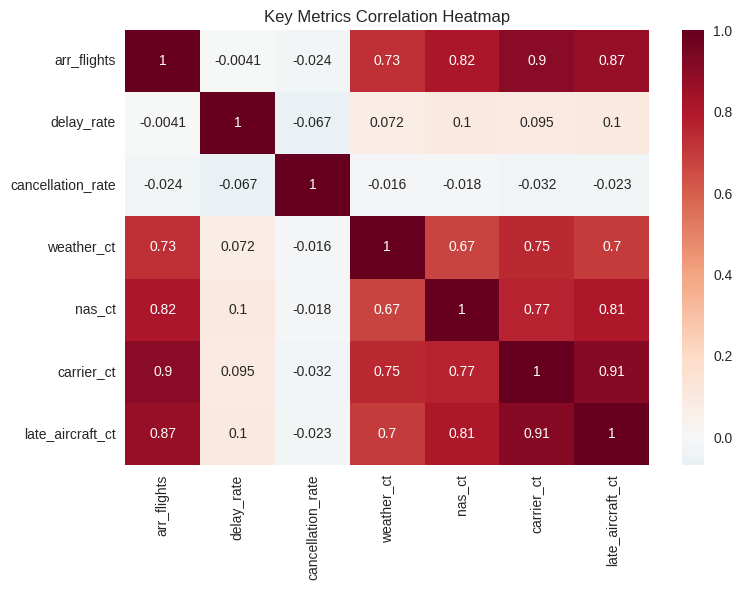

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
key_metrics = ['arr_flights', 'delay_rate', 'cancellation_rate', 'weather_ct', 'nas_ct', 'carrier_ct', 'late_aircraft_ct']
available_key_metrics = [col for col in key_metrics if col in df.columns]

sns.heatmap(
    df[available_key_metrics].corr(),
    annot=True,
    cmap='RdBu_r',
    center=0,
    ax=ax
)
ax.set_title('Key Metrics Correlation Heatmap')
plt.tight_layout()
plt.show()


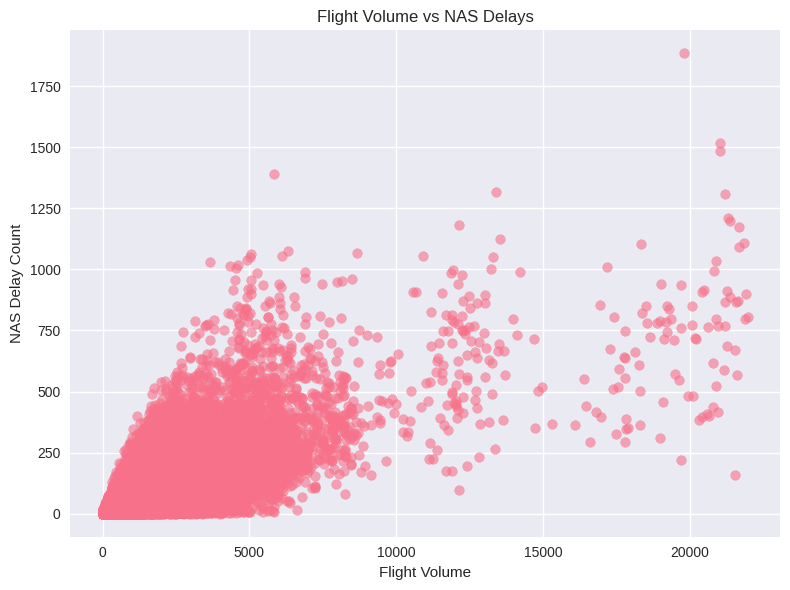

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df['arr_flights'], df['nas_ct'], alpha=0.6)
ax.set_xlabel('Flight Volume')
ax.set_ylabel('NAS Delay Count')
ax.set_title('Flight Volume vs NAS Delays')
plt.tight_layout()
plt.show()


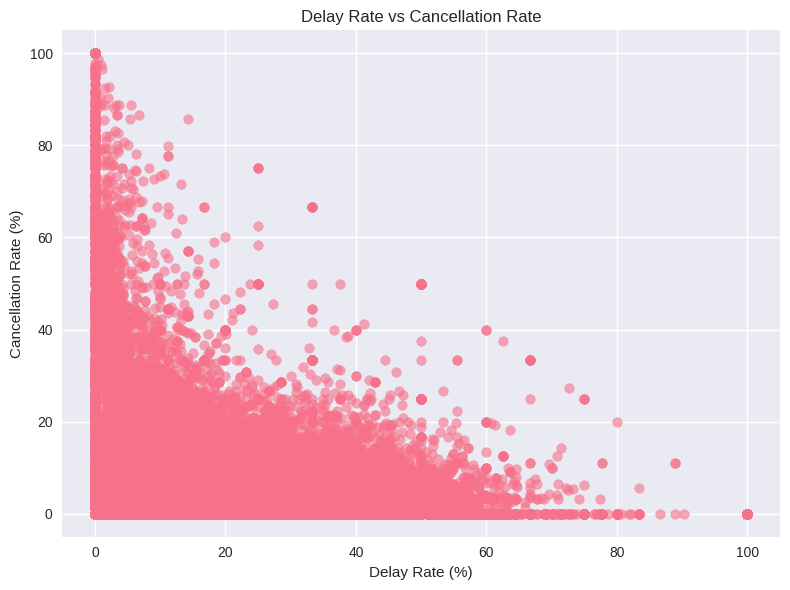

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df['delay_rate'], df['cancellation_rate'], alpha=0.6)
ax.set_xlabel('Delay Rate (%)')
ax.set_ylabel('Cancellation Rate (%)')
ax.set_title('Delay Rate vs Cancellation Rate')
plt.tight_layout()
plt.show()


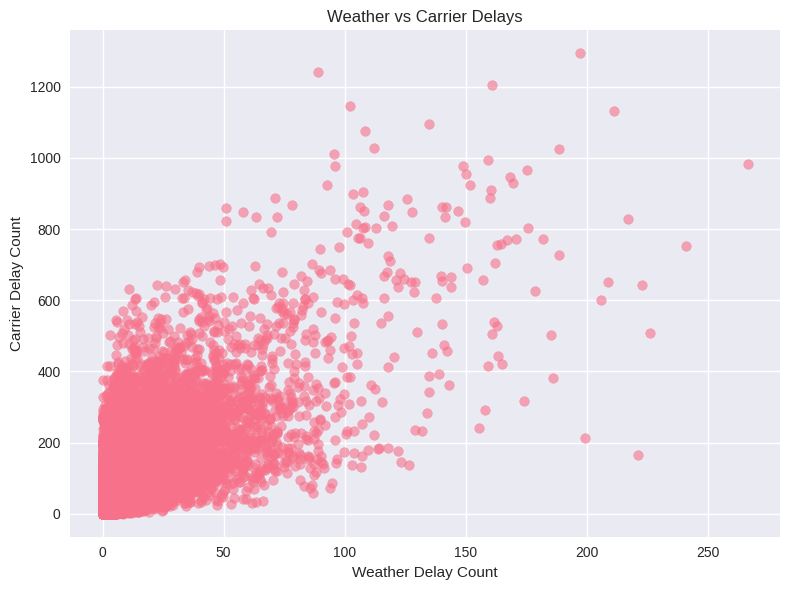

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
if 'weather_ct' in df.columns and 'carrier_ct' in df.columns:
    ax.scatter(df['weather_ct'], df['carrier_ct'], alpha=0.6)
    ax.set_xlabel('Weather Delay Count')
    ax.set_ylabel('Carrier Delay Count')
    ax.set_title('Weather vs Carrier Delays')
    plt.tight_layout()
    plt.show()


In [ ]:
def generate_comprehensive_summary(df):
    """Generate comprehensive summary of all analyses"""

    print("\n" + "="*80)
    print("COMPREHENSIVE EDA SUMMARY REPORT")
    print("="*80)

    print(f"""
DATASET OVERVIEW:
- Total Records: {len(df):,}
- Date Range: {df['month'].min()}/{df['year'].min()} to {df['month'].max()}/{df['year'].max()}
- Carriers: {df['carrier_name'].nunique()}
- Airports: {df['airport'].nunique()}
- Total Flights: {df['arr_flights'].sum():,}
- Total Delays (15+ min): {df['arr_del15'].sum():,}
- Total Delay Minutes: {df['arr_delay'].sum():,}
- Total Cancellations: {df['arr_cancelled'].sum():,}
    """)

    overall_delay_rate = (df['arr_del15'].sum() / df['arr_flights'].sum()) * 100
    overall_cancellation_rate = (df['arr_cancelled'].sum() / df['arr_flights'].sum()) * 100
    avg_delay_per_delayed_flight = df['arr_delay'].sum() / df['arr_del15'].sum() if df['arr_del15'].sum() > 0 else 0

    print(f"""
KEY PERFORMANCE INDICATORS:
- Overall Delay Rate: {overall_delay_rate:.2f}%
- Overall Cancellation Rate: {overall_cancellation_rate:.2f}%
- Average Delay per Delayed Flight: {avg_delay_per_delayed_flight:.1f} minutes
    """)


    carrier_summary = df.groupby('carrier_name').agg({
        'arr_flights': 'sum',
        'arr_del15': 'sum',
        'arr_delay': 'sum',
        'arr_cancelled': 'sum'
    })

    carrier_summary['delay_rate'] = (carrier_summary['arr_del15'] / carrier_summary['arr_flights']) * 100
    carrier_summary['cancellation_rate'] = (carrier_summary['arr_cancelled'] / carrier_summary['arr_flights']) * 100

    print("\nCARRIER PERFORMANCE RANKINGS:")
    print("Best Performers (Lowest Delay Rate):")
    print(carrier_summary.nsmallest(3, 'delay_rate')[['delay_rate', 'cancellation_rate']].round(2))

    print("\nWorst Performers (Highest Delay Rate):")
    print(carrier_summary.nlargest(3, 'delay_rate')[['delay_rate', 'cancellation_rate']].round(2))

    airport_summary = df.groupby(['airport', 'airport_name']).agg({
        'arr_flights': 'sum',
        'arr_del15': 'sum',
        'arr_delay': 'sum'
    }).reset_index()

    airport_summary['delay_rate'] = (airport_summary['arr_del15'] / airport_summary['arr_flights']) * 100

    print("\nAIRPORT PERFORMANCE:")
    print("Most Problematic Airports (Highest Total Delay Minutes):")
    problem_airports = airport_summary.nlargest(5, 'arr_delay')[['airport_name', 'arr_delay', 'delay_rate']]
    print(problem_airports.round(1))

    cause_totals = {
        'Carrier': df['carrier_ct'].sum(),
        'Weather': df['weather_ct'].sum(),
        'NAS': df['nas_ct'].sum(),
        'Security': df['security_ct'].sum(),
        'Late Aircraft': df['late_aircraft_ct'].sum()
    }

    total_causes = sum(cause_totals.values())

    print("\nDELAY CAUSE BREAKDOWN:")
    for cause, count in sorted(cause_totals.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / total_causes) * 100 if total_causes > 0 else 0
        print(f"- {cause}: {count:,} incidents ({percentage:.1f}%)")


    missing_data = df.isnull().sum().sum()
    duplicates = len(df[df.duplicated(subset=['year', 'month', 'carrier', 'airport'])])
    zero_flights = len(df[df['arr_flights'] == 0])

    print(f"""
DATA QUALITY SUMMARY:
- Missing Values: {missing_data}
- Duplicate Records: {duplicates}
- Zero Flight Records: {zero_flights}
- Data Completeness: {((len(df) * len(df.columns) - missing_data) / (len(df) * len(df.columns))) * 100:.1f}%
    """)

    print("""
KEY RECOMMENDATIONS:
1. Focus on carriers with consistently high delay rates for operational improvements
2. Investigate airports with high NAS delays for infrastructure bottlenecks
3. Develop weather contingency plans for weather-sensitive routes
4. Implement better schedule padding for carriers with high late aircraft propagation
5. Monitor data quality, especially zero-flight records and missing values
6. Consider seasonal analysis when more temporal data becomes available
    """)

    print("="*80)
    print("EDA ANALYSIS COMPLETE")
    print("="*80)

generate_comprehensive_summary(df)



COMPREHENSIVE EDA SUMMARY REPORT

DATASET OVERVIEW:
- Total Records: 179,338
- Date Range: 1/2015 to 12/2023
- Carriers: 39
- Airports: 396
- Total Flights: 58,678,254.0
- Total Delays (15+ min): 10,494,073.0
- Total Delay Minutes: 691,521,021.0
- Total Cancellations: 1,222,568.0
    

KEY PERFORMANCE INDICATORS:
- Overall Delay Rate: 17.88%
- Overall Cancellation Rate: 2.08%
- Average Delay per Delayed Flight: 65.9 minutes
    

CARRIER PERFORMANCE RANKINGS:
Best Performers (Lowest Delay Rate):
                        delay_rate  cancellation_rate
carrier_name                                         
Cape Air                      8.91               0.12
Hawaiian Airlines Inc.       10.46               0.22
Delta Air Lines Inc.         13.26               0.62

Worst Performers (Highest Delay Rate):
                        delay_rate  cancellation_rate
carrier_name                                         
Peninsula Airways Inc.       31.45              15.62
Frontier Airlines         

# **Temporal Analysis**

In [ ]:
def prepare_temporal_data(df):
    """Prepare data for temporal analysis"""

    print("="*60)
    print("TEMPORAL DATA PREPARATION")
    print("="*60)

    df_temp = df.copy()
    df_temp['date'] = pd.to_datetime(df_temp[['year', 'month']].assign(day=1))

    df_temp['quarter'] = df_temp['date'].dt.quarter
    df_temp['month_name'] = df_temp['date'].dt.month_name()
    df_temp['year_month'] = df_temp['date'].dt.to_period('M')

    df_temp['delay_rate'] = (df_temp['arr_del15'] / df_temp['arr_flights']) * 100
    df_temp['delay_rate'] = df_temp['delay_rate'].fillna(0)

    df_temp['cancellation_rate'] = (df_temp['arr_cancelled'] / df_temp['arr_flights']) * 100
    df_temp['cancellation_rate'] = df_temp['cancellation_rate'].fillna(0)

    df_temp['avg_delay_per_flight'] = df_temp['arr_delay'] / df_temp['arr_flights']
    df_temp['avg_delay_per_flight'] = df_temp['avg_delay_per_flight'].fillna(0)

    print(f"Date Range: {df_temp['date'].min()} to {df_temp['date'].max()}")
    print(f"Total Time Periods: {df_temp['year_month'].nunique()}")
    print(f"Years Covered: {sorted(df_temp['year'].unique())}")
    print(f"Months Covered: {sorted(df_temp['month'].unique())}")

    if 'weekday' in df_temp.columns:
        print(f"Days of Week Available: {sorted(df_temp['weekday_name'].unique())}")

    return df_temp

df_temporal = prepare_temporal_data(df)


TEMPORAL DATA PREPARATION
Date Range: 2015-01-01 00:00:00 to 2023-12-01 00:00:00
Total Time Periods: 108
Years Covered: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
Months Covered: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)]


In [ ]:
from scipy import stats
import numpy as np

def time_series_trend_analysis_text(df_temporal):
    print("\n" + "="*60)
    print("TIME SERIES TREND ANALYSIS")
    print("="*60)

    monthly_trends = df_temporal.groupby('year_month').agg({
        'arr_flights': 'sum',
        'arr_del15': 'sum',
        'arr_delay': 'sum',
        'arr_cancelled': 'sum',
        'carrier_ct': 'sum',
        'weather_ct': 'sum',
        'nas_ct': 'sum',
        'late_aircraft_ct': 'sum',
        'carrier_delay': 'sum',
        'weather_delay': 'sum',
        'nas_delay': 'sum',
        'late_aircraft_delay': 'sum'
    }).reset_index()

    monthly_trends['delay_rate'] = (monthly_trends['arr_del15'] / monthly_trends['arr_flights']) * 100
    monthly_trends['cancellation_rate'] = (monthly_trends['arr_cancelled'] / monthly_trends['arr_flights']) * 100
    monthly_trends['avg_delay_per_flight'] = monthly_trends['arr_delay'] / monthly_trends['arr_flights']
    monthly_trends = monthly_trends.fillna(0)
    monthly_trends['date'] = monthly_trends['year_month'].dt.to_timestamp()

    print("\n--- MONTHLY PERFORMANCE TRENDS ---")
    print(monthly_trends[['year_month', 'arr_flights', 'delay_rate', 'cancellation_rate', 'avg_delay_per_flight']].round(2))

    if len(monthly_trends) > 1:
        print("\n--- MONTH-OVER-MONTH CHANGES ---")
        monthly_trends['flights_change'] = monthly_trends['arr_flights'].pct_change() * 100
        monthly_trends['delay_rate_change'] = monthly_trends['delay_rate'].diff()
        monthly_trends['cancellation_rate_change'] = monthly_trends['cancellation_rate'].diff()
        print(monthly_trends[['year_month', 'flights_change', 'delay_rate_change', 'cancellation_rate_change']].dropna().round(2))

    print("\n--- TREND STATISTICS ---")
    if len(monthly_trends) > 2:
        x = np.arange(len(monthly_trends))

        delay_slope, _, delay_r, delay_p, _ = stats.linregress(x, monthly_trends['delay_rate'])
        print(f"Delay Rate Trend: {'Increasing' if delay_slope > 0 else 'Decreasing'} by {abs(delay_slope):.3f}% per month")
        print(f"Delay Rate R²: {delay_r**2:.3f}, P-value: {delay_p:.3f}")

        flights_slope, _, flights_r, flights_p, _ = stats.linregress(x, monthly_trends['arr_flights'])
        print(f"Flight Volume Trend: {'Increasing' if flights_slope > 0 else 'Decreasing'} by {abs(flights_slope):.0f} flights per month")
        print(f"Flight Volume R²: {flights_r**2:.3f}, P-value: {flights_p:.3f}")

    return monthly_trends

monthly_trends = time_series_trend_analysis_text(df_temporal)



TIME SERIES TREND ANALYSIS

--- MONTHLY PERFORMANCE TRENDS ---
    year_month  arr_flights  delay_rate  cancellation_rate  avg_delay_per_flight
0      2015-01     469968.0       20.42               2.55                 11.57
1      2015-02     429191.0       22.18               4.78                 13.13
2      2015-03     504312.0       18.93               2.18                 10.78
3      2015-04     485151.0       16.95               0.93                  9.52
4      2015-05     496993.0       18.04               1.15                 10.94
..         ...          ...         ...                ...                   ...
103    2023-08     640236.0       21.07               1.48                 15.50
104    2023-09     604715.0       18.27               1.24                 12.94
105    2023-10     635538.0       15.42               0.34                  9.60
106    2023-11     599814.0       13.46               0.14                  8.13
107    2023-12     606218.0       15.53      

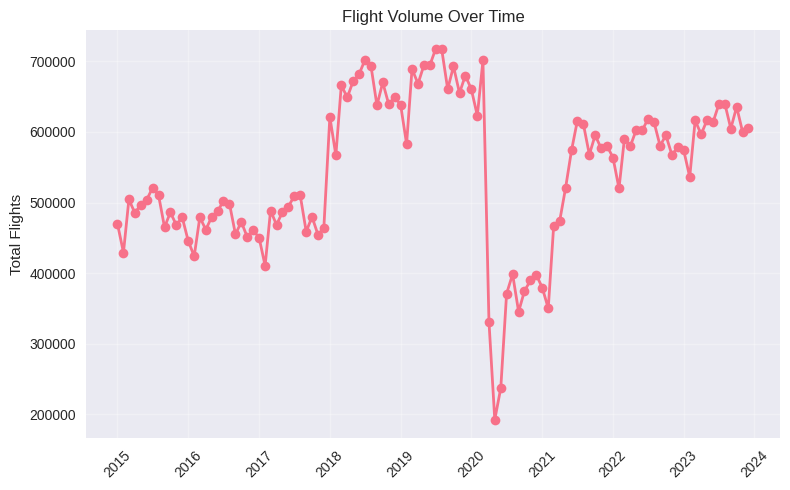

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(monthly_trends['date'], monthly_trends['arr_flights'], marker='o', linewidth=2)
plt.title('Flight Volume Over Time')
plt.ylabel('Total Flights')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


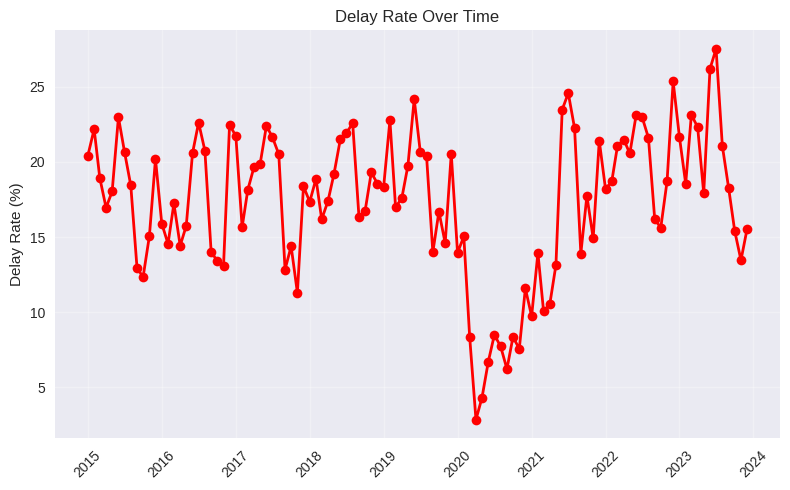

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(monthly_trends['date'], monthly_trends['delay_rate'], marker='o', linewidth=2, color='red')
plt.title('Delay Rate Over Time')
plt.ylabel('Delay Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


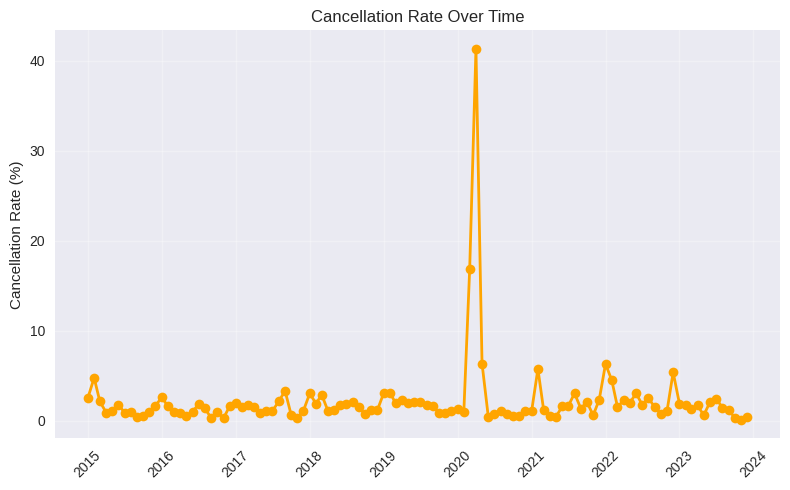

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(monthly_trends['date'], monthly_trends['cancellation_rate'], marker='o', linewidth=2, color='orange')
plt.title('Cancellation Rate Over Time')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


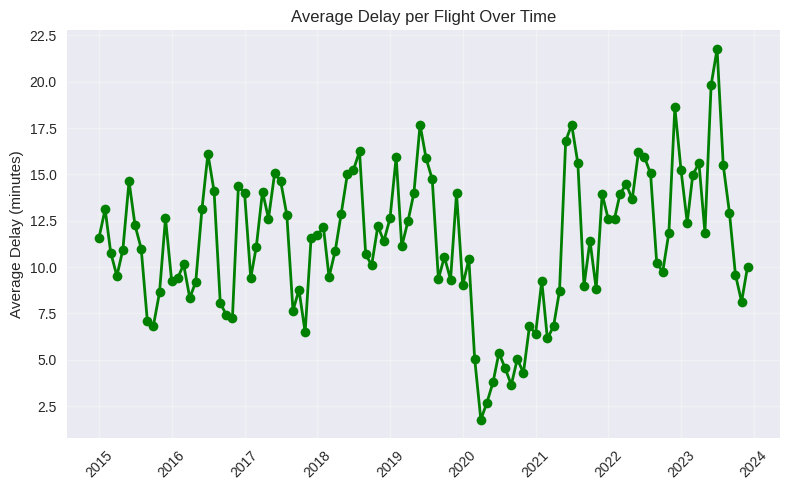

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(monthly_trends['date'], monthly_trends['avg_delay_per_flight'], marker='o', linewidth=2, color='green')
plt.title('Average Delay per Flight Over Time')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


This plot shows that Average Delay per Flight fluctuates over time. We can observe periods with higher or lower average delays, indicating shifts in operational efficiency or external factors affecting flight punctuality.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    STATSMODELS_AVAILABLE = True
except ImportError:
    print("statsmodels not available. Some advanced time series features will be limited.")
    STATSMODELS_AVAILABLE = False

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [ ]:
def seasonal_pattern_analysis_text(df_temporal):
    """Analyze seasonal patterns and print text-based summaries"""
    print("\n" + "="*60)
    print("SEASONAL PATTERN ANALYSIS")
    print("="*60)

    print("\n--- MONTHLY SEASONALITY ---")
    monthly_seasonality = df_temporal.groupby('month').agg({
        'arr_flights': 'sum',
        'arr_del15': 'sum',
        'arr_delay': 'sum',
        'arr_cancelled': 'sum',
        'weather_ct': 'sum',
        'weather_delay': 'sum'
    })

    monthly_seasonality['delay_rate'] = (monthly_seasonality['arr_del15'] / monthly_seasonality['arr_flights']) * 100
    monthly_seasonality['cancellation_rate'] = (monthly_seasonality['arr_cancelled'] / monthly_seasonality['arr_flights']) * 100
    monthly_seasonality['weather_impact'] = (monthly_seasonality['weather_delay'] / monthly_seasonality['arr_delay']) * 100
    monthly_seasonality = monthly_seasonality.fillna(0)

    month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                   7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    monthly_seasonality['month_name'] = monthly_seasonality.index.map(month_names)

    print("Monthly Performance Summary:")
    print(monthly_seasonality[['month_name', 'arr_flights', 'delay_rate', 'cancellation_rate', 'weather_impact']].round(2))

    print("\n--- QUARTERLY SEASONALITY ---")
    quarterly_seasonality = df_temporal.groupby('quarter').agg({
        'arr_flights': 'sum',
        'delay_rate': 'mean',
        'cancellation_rate': 'mean',
        'weather_ct': 'sum',
        'nas_ct': 'sum'
    }).round(2)

    quarter_names = {1: 'Q1 (Winter)', 2: 'Q2 (Spring)', 3: 'Q3 (Summer)', 4: 'Q4 (Fall)'}
    quarterly_seasonality['quarter_name'] = quarterly_seasonality.index.map(quarter_names)

    print("Quarterly Performance Summary:")
    print(quarterly_seasonality)

    print("\n--- WEATHER SEASONALITY ---")
    weather_seasonality = df_temporal.groupby('month').agg({
        'weather_ct': 'sum',
        'weather_delay': 'sum',
        'arr_flights': 'sum'
    })

    weather_seasonality['weather_delay_rate'] = (weather_seasonality['weather_ct'] / weather_seasonality['arr_flights']) * 100
    weather_seasonality['avg_weather_delay_per_incident'] = weather_seasonality['weather_delay'] / (weather_seasonality['weather_ct'] + 1)
    weather_seasonality['month_name'] = weather_seasonality.index.map(month_names)

    print("Weather Impact by Month:")
    print(weather_seasonality[['month_name', 'weather_ct', 'weather_delay_rate', 'avg_weather_delay_per_incident']].round(2))

    print("\n--- PEAK vs OFF-PEAK ANALYSIS ---")
    peak_months = [6, 7, 8]
    df_temporal['season_type'] = df_temporal['month'].apply(lambda x: 'Peak' if x in peak_months else 'Off-Peak')

    peak_analysis = df_temporal.groupby('season_type').agg({
        'arr_flights': 'sum',
        'delay_rate': 'mean',
        'cancellation_rate': 'mean',
        'avg_delay_per_flight': 'mean',
        'weather_ct': 'sum',
        'nas_ct': 'sum'
    }).round(2)

    print("Peak vs Off-Peak Performance:")
    print(peak_analysis)

    return monthly_seasonality, quarterly_seasonality, weather_seasonality, peak_analysis


In [ ]:
monthly_seasonality, quarterly_seasonality, weather_seasonality, peak_analysis=seasonal_pattern_analysis_text(df_temporal)


SEASONAL PATTERN ANALYSIS

--- MONTHLY SEASONALITY ---
Monthly Performance Summary:
      month_name  arr_flights  delay_rate  cancellation_rate  weather_impact
month                                                                       
1            Jan    4803413.0       17.60               2.71            6.25
2            Feb    4442948.0       18.01               2.75            6.76
3            Mar    5202250.0       16.60               3.81            4.24
4            Apr    4714532.0       16.73               4.29            4.97
5            May    4760930.0       17.63               1.37            5.53
6            Jun    4888960.0       22.33               1.80            5.64
7            Jul    5196159.0       21.82               1.69            5.89
8            Aug    5194421.0       20.01               1.89            5.72
9            Sep    4775209.0       14.33               1.38            4.92
10           Oct    5002420.0       14.96               0.87        

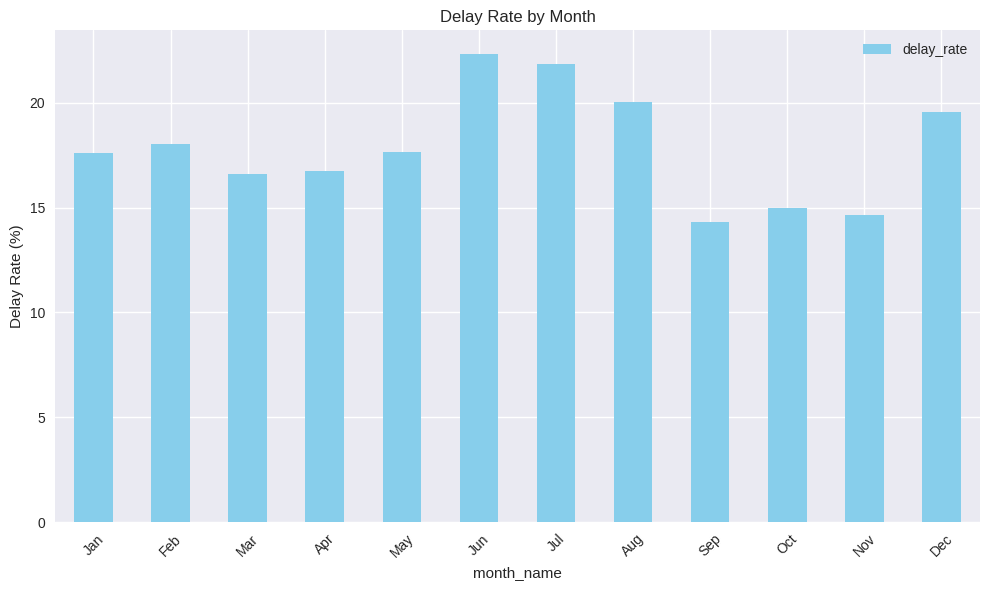

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

monthly_seasonality.plot(x='month_name', y='delay_rate', kind='bar', ax=ax, color='skyblue')
ax.set_title('Delay Rate by Month')
ax.set_ylabel('Delay Rate (%)')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


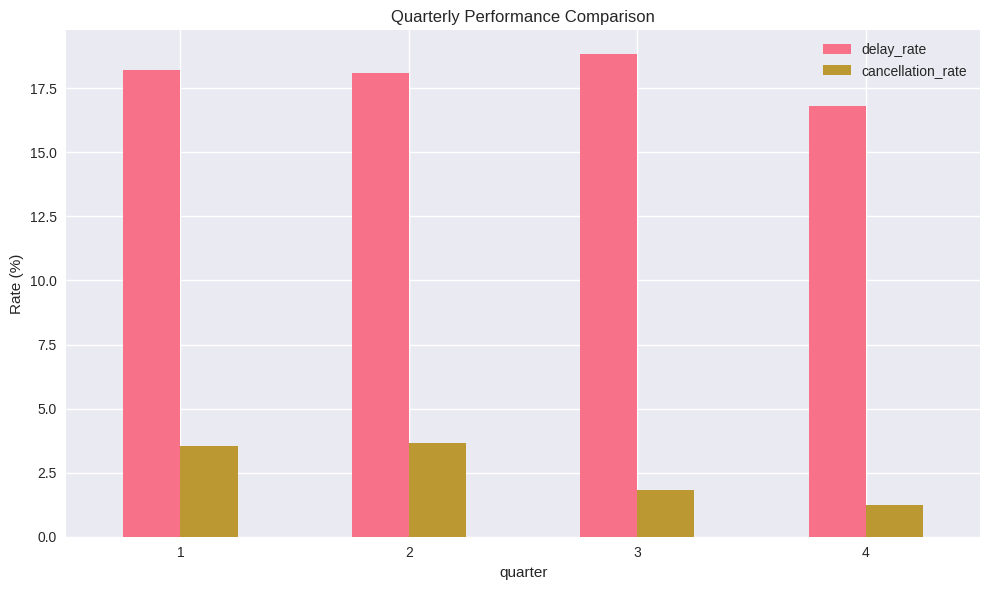

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
quarterly_seasonality.plot(y=['delay_rate', 'cancellation_rate'], kind='bar', ax=ax)
ax.set_title('Quarterly Performance Comparison')
ax.set_ylabel('Rate (%)')
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()


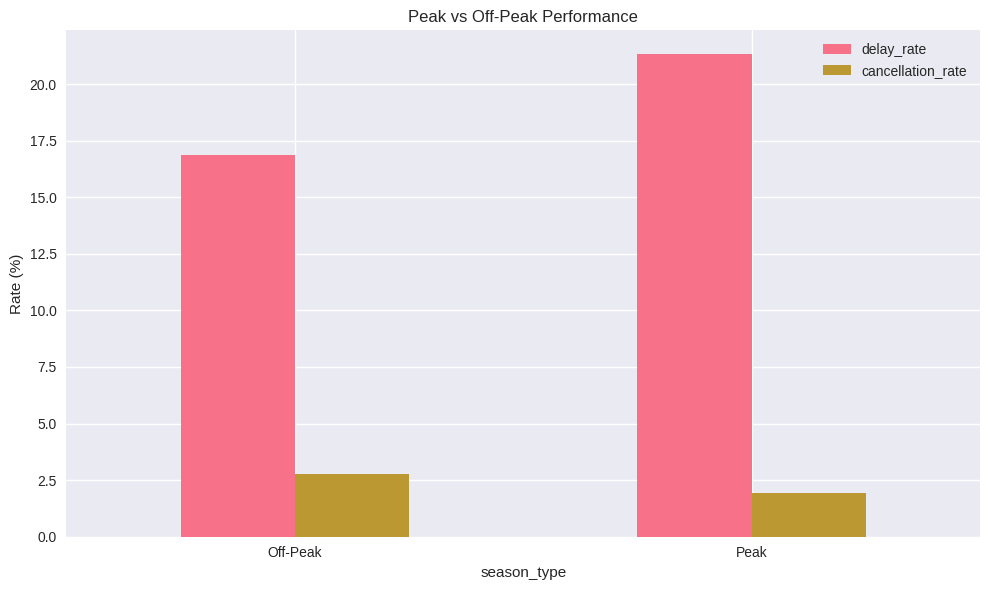

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
peak_analysis[['delay_rate', 'cancellation_rate']].plot(kind='bar', ax=ax)
ax.set_title('Peak vs Off-Peak Performance')
ax.set_ylabel('Rate (%)')
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()


## Key Carrier Performance Insights

1. **Trend Analysis:**  
   We focus on the delay‐rate trends of the top 3 carriers by flight volume. This reveals which airlines are improving or degrading in on‐time performance over the study period.

2. **Consistency Analysis:**  
   The coefficient of variation (CV) of delay rate measures stability. Carriers with low CV are reliably consistent, even if their absolute delay rate isn’t the lowest.

These two views together give both directional (trend) and reliability (consistency) perspectives—critical for operational benchmarking and improvement planning.


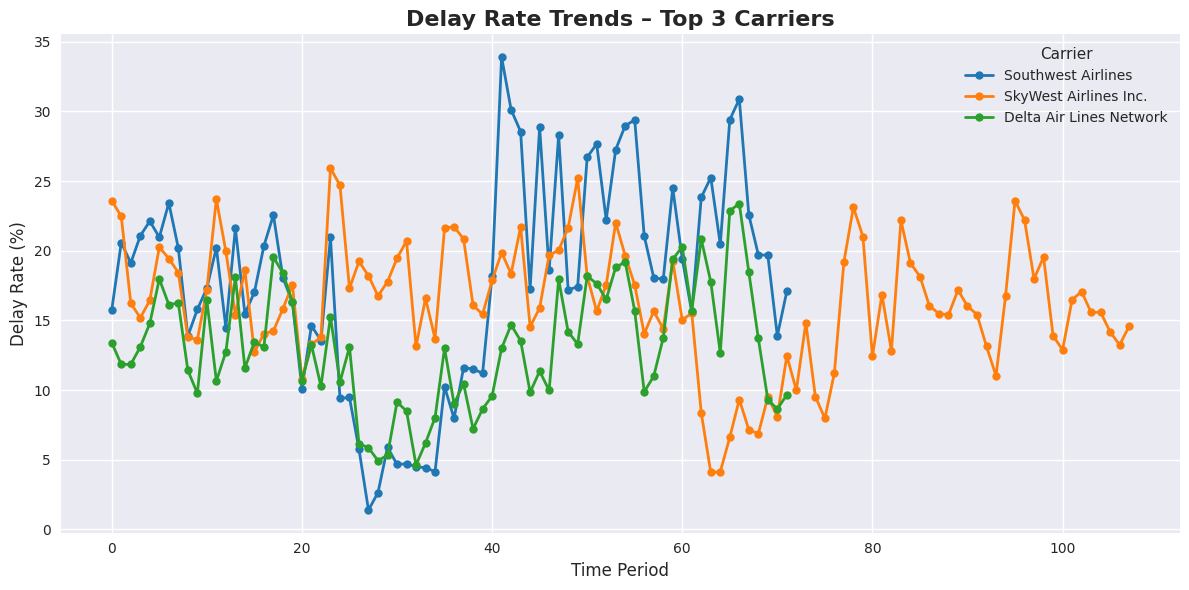

In [ ]:
sns.set_style("darkgrid")
palette = sns.color_palette("tab10", n_colors=len(top3))

carrier_monthly = (
    df_temporal
    .groupby(['carrier_name', 'year_month'])
    .agg(delay_rate=('arr_del15', lambda x: 100 * x.sum() / df_temporal.loc[x.index, 'arr_flights'].sum()))
    .reset_index()
)

plt.figure(figsize=(12,6))
for idx, carrier in enumerate(top3):
    data = carrier_monthly[carrier_monthly['carrier_name'] == carrier].sort_values('year_month')
    x = np.arange(len(data))
    plt.plot(
        x,
        data['delay_rate'],
        label=carrier,
        marker="o",
        markersize=6,
        linewidth=2,
        color=palette[idx]
    )

plt.title("Delay Rate Trends – Top 3 Carriers", fontsize=16, fontweight="bold")
plt.xlabel("Time Period", fontsize=12)
plt.ylabel("Delay Rate (%)", fontsize=12)
plt.legend(title="Carrier", fontsize=10, title_fontsize=11)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


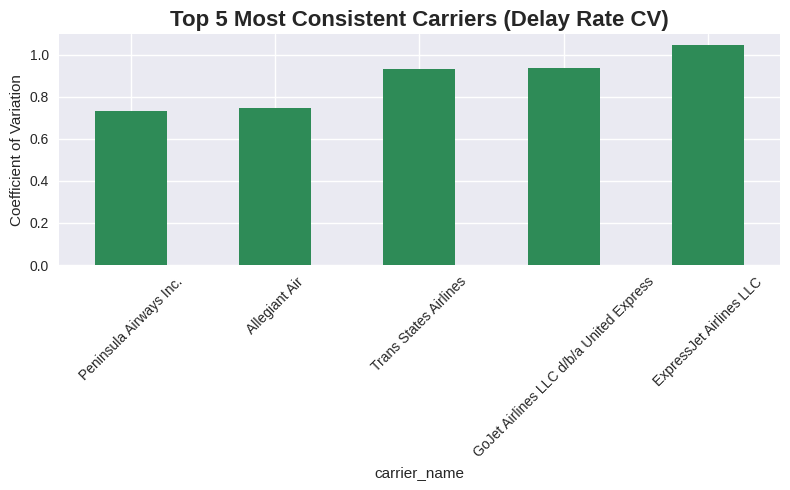

In [ ]:
consistency = df_temporal.groupby('carrier_name') \
    .agg(
        mean_delay=('arr_del15', lambda x: x.sum()/df_temporal.loc[x.index,'arr_flights'].sum()*100),
        std_delay=('arr_del15', lambda x: x.abs().mean())
    ).assign(
        cv=lambda d: d.std_delay / d.mean_delay
    ).sort_values('cv')

plt.figure(figsize=(8,5))
consistency['cv'].head(5).plot(kind='bar', color='seagreen')
plt.title('Top 5 Most Consistent Carriers (Delay Rate CV)', fontsize=16, fontweight='bold')
plt.ylabel('Coefficient of Variation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
def airport_temporal_performance_analysis(df_temporal):
    """Analyze airport performance patterns over time (text outputs only)"""

    # --- Compute seasonal delay rates ---
    airport_seasonal = df_temporal.groupby(['airport', 'airport_name', 'month']).agg(
        delay_rate=('arr_del15', lambda x: 100 * x.sum() / df_temporal.loc[x.index, 'arr_flights'].sum()),
        weather_ct=('weather_ct', 'sum'),
        nas_ct=('nas_ct', 'sum'),
        arr_flights=('arr_flights', 'sum')
    ).reset_index()

    # --- Weather-Sensitive Airports ---
    weather_sensitive = (
        airport_seasonal
        .groupby('airport_name')
        .agg(weather_ct=('weather_ct','sum'), arr_flights=('arr_flights','sum'))
        .assign(weather_rate=lambda d: 100 * d.weather_ct / d.arr_flights)
        .sort_values('weather_rate', ascending=False)
        .round(2)
    )

    print("\nMost Weather-Sensitive Airports:")
    print(weather_sensitive[['weather_rate','weather_ct']].head(10))

    # --- Congested Airports (NAS delays) ---
    congested = (
        airport_seasonal
        .groupby('airport_name')
        .agg(nas_ct=('nas_ct','sum'), arr_flights=('arr_flights','sum'))
        .assign(nas_rate=lambda d: 100 * d.nas_ct / d.arr_flights)
        .sort_values('nas_rate', ascending=False)
        .round(2)
    )

    print("\nMost Congested Airports (NAS Delays):")
    print(congested[['nas_rate','nas_ct']].head(10))

    return airport_seasonal, weather_sensitive, congested

# Call the function
airport_seasonal, weather_sensitive_airports, congested_airports = \
    airport_temporal_performance_analysis(df_temporal)



Most Weather-Sensitive Airports:
                                                    weather_rate  weather_ct
airport_name                                                                
Marquette, MI: Sawyer International                         2.69      232.79
Unalaska, AK: Unalaska Airport                              2.57       41.43
Hagerstown, MD: Hagerstown Regional-Richard A. ...          2.33       25.97
Lewisburg, WV: Greenbrier Valley                            2.32       70.14
Columbus, OH: Rickenbacker International                    2.11      133.18
Pellston, MI: Pellston Regional Airport of Emme...          2.10      174.18
Alpena, MI: Alpena County Regional                          2.10      114.19
Nantucket, MA: Nantucket Memorial                           2.07      227.84
Belleville, IL: Scott AFB/MidAmerica                        1.96       81.37
Williston, ND: Williston Basin International                1.92      108.06

Most Congested Airports (NAS Delays):
   

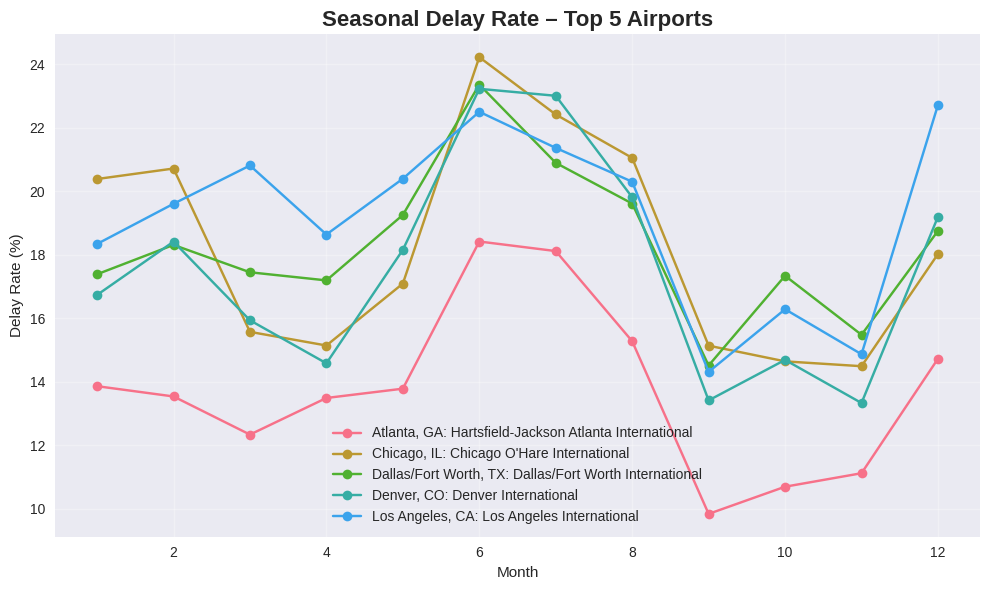

In [ ]:
airport_seasonal = df_temporal.groupby(['airport_name', 'month']) \
    .agg(delay_rate=('arr_del15', lambda x: x.sum() / df_temporal.loc[x.index, 'arr_flights'].sum() * 100)) \
    .reset_index()

top5 = (df_temporal.groupby('airport_name')['arr_flights']
         .sum()
         .nlargest(5)
         .index.tolist())

plt.figure(figsize=(10,6))
for name in top5:
    subset = airport_seasonal[airport_seasonal['airport_name'] == name]
    plt.plot(subset['month'], subset['delay_rate'], marker='o', label=name)

plt.title('Seasonal Delay Rate – Top 5 Airports', fontsize=16, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Delay Rate (%)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

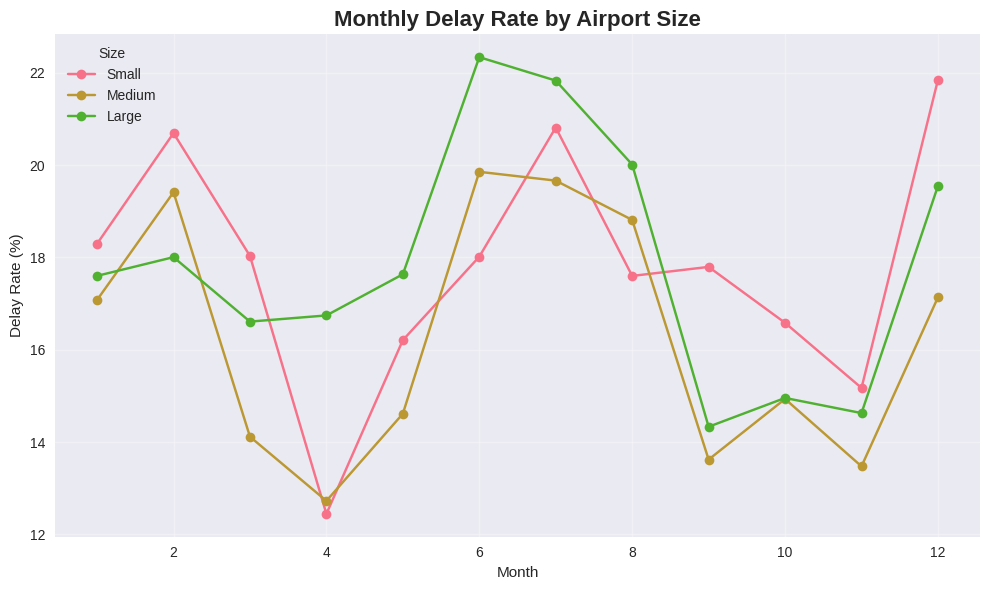

In [ ]:
sizes = (df_temporal.groupby('airport')['arr_flights']
           .sum()
           .reset_index(name='total_flights'))
sizes['size_cat'] = pd.cut(
    sizes['total_flights'],
    bins=[0,1000,5000,float('inf')],
    labels=['Small','Medium','Large']
)

df_sz = df_temporal.merge(sizes[['airport','size_cat']], on='airport')

size_monthly = df_sz.groupby(['size_cat','month']) \
    .agg(delay_rate=('arr_del15', lambda x: x.sum()/df_sz.loc[x.index,'arr_flights'].sum()*100)) \
    .reset_index()

plt.figure(figsize=(10,6))
for sz in ['Small','Medium','Large']:
    sub = size_monthly[size_monthly['size_cat']==sz]
    plt.plot(sub['month'], sub['delay_rate'], marker='o', label=sz)

plt.title('Monthly Delay Rate by Airport Size', fontsize=16, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Delay Rate (%)')
plt.legend(title='Size')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

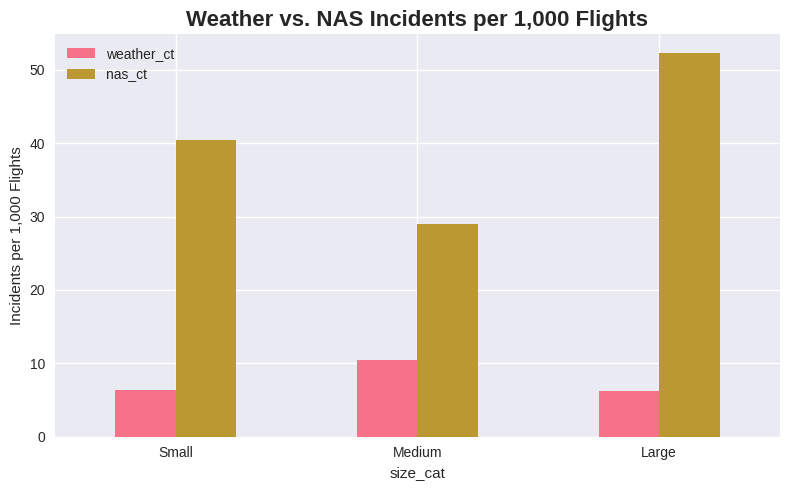

In [ ]:
sz_totals = df_sz.groupby('size_cat').agg({
    'weather_ct': 'sum',
    'nas_ct':     'sum',
    'arr_flights':'sum'
})

per_1000 = sz_totals[['weather_ct','nas_ct']].div(sz_totals['arr_flights'], axis=0) * 1000

fig, ax = plt.subplots(figsize=(8, 5))
per_1000.plot(kind='bar', ax=ax)

ax.set_title('Weather vs. NAS Incidents per 1,000 Flights',
             fontsize=16, fontweight='bold')
ax.set_ylabel('Incidents per 1,000 Flights')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()


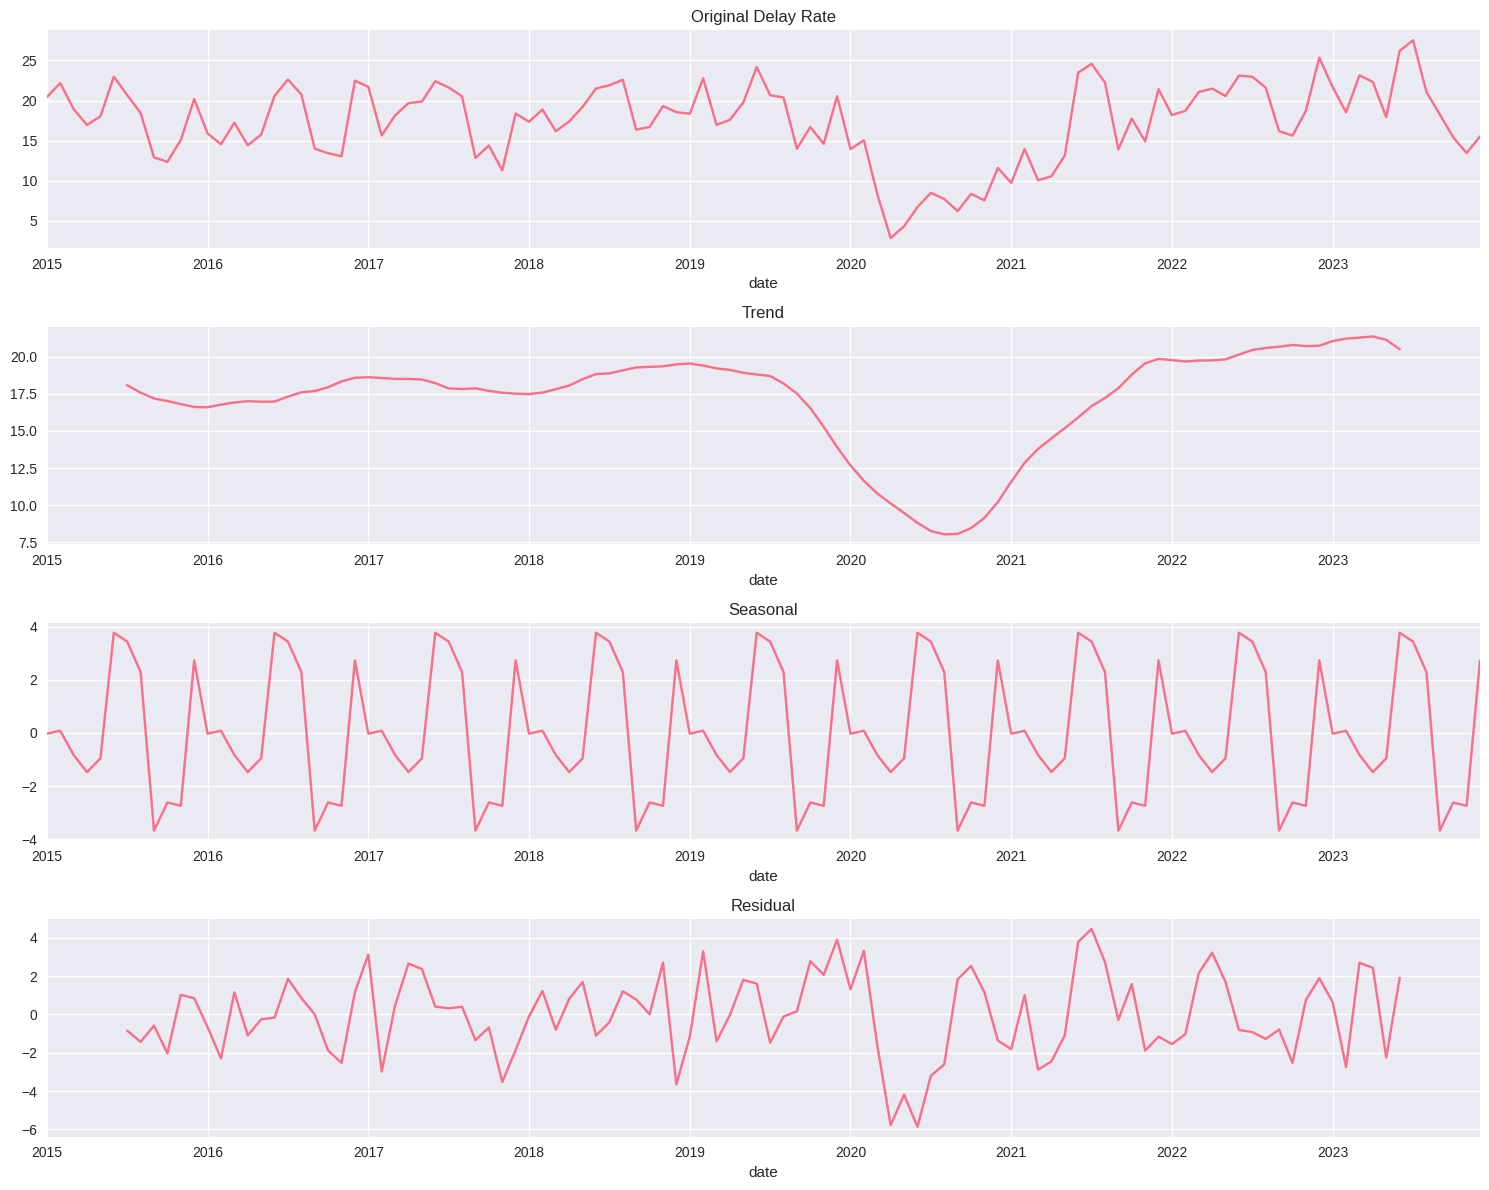

Seasonal amplitude: 7.46%
Trend direction: Decreasing


In [ ]:
if STATSMODELS_AVAILABLE and len(monthly_trends) >= 24:
    ts_data = monthly_trends.set_index('date')['delay_rate']
    decomposition = seasonal_decompose(ts_data, model='additive', period=12)

    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    decomposition.observed.plot(ax=axes[0], title='Original Delay Rate')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')
    plt.tight_layout()
    plt.show()

    print(f"Seasonal amplitude: {decomposition.seasonal.max() - decomposition.seasonal.min():.2f}%")
    print(f"Trend direction: {'Increasing' if decomposition.trend.iloc[-1] > decomposition.trend.iloc[0] else 'Decreasing'}")


In [ ]:
def comprehensive_temporal_summary(df_temporal, monthly_trends):
    """Generate comprehensive temporal analysis summary"""

    print("\n" + "="*80)
    print("COMPREHENSIVE TEMPORAL ANALYSIS SUMMARY")
    print("="*80)

    total_periods = df_temporal['year_month'].nunique()
    date_range = f"{df_temporal['date'].min().strftime('%Y-%m')} to {df_temporal['date'].max().strftime('%Y-%m')}"

    print(f"""
TEMPORAL DATASET CHARACTERISTICS:
- Analysis Period: {date_range}
- Total Time Periods: {total_periods}
- Years Covered: {', '.join(map(str, sorted(df_temporal['year'].unique())))}
- Months Covered: {', '.join(map(str, sorted(df_temporal['month'].unique())))}
- Total Records: {len(df_temporal):,}
    """)

    if len(monthly_trends) > 1:
        print("\nOVERALL PERFORMANCE TRENDS:")

        initial_delay_rate = monthly_trends['delay_rate'].iloc[0]
        final_delay_rate = monthly_trends['delay_rate'].iloc[-1]
        delay_rate_change = final_delay_rate - initial_delay_rate

        initial_flights = monthly_trends['arr_flights'].iloc[0]
        final_flights = monthly_trends['arr_flights'].iloc[-1]
        flights_change = ((final_flights - initial_flights) / initial_flights) * 100 if initial_flights > 0 else 0

        print(f"- Delay Rate Change: {delay_rate_change:+.2f} percentage points")
        print(f"- Flight Volume Change: {flights_change:+.1f}%")
        print(f"- Performance Trend: {'Improving' if delay_rate_change < 0 else 'Declining'}")

    print("\nSEASONAL INSIGHTS:")

    monthly_performance = df_temporal.groupby('month').agg({
        'delay_rate': 'mean',
        'weather_ct': 'sum',
        'nas_ct': 'sum',
        'arr_flights': 'sum'
    })

    best_month = monthly_performance['delay_rate'].idxmin()
    worst_month = monthly_performance['delay_rate'].idxmax()

    month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
                   7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

    print(f"- Best Performance Month: {month_names[best_month]} ({monthly_performance.loc[best_month, 'delay_rate']:.1f}% delay rate)")
    print(f"- Worst Performance Month: {month_names[worst_month]} ({monthly_performance.loc[worst_month, 'delay_rate']:.1f}% delay rate)")

    weather_month = monthly_performance['weather_ct'].idxmax()
    print(f"- Most Weather-Impacted Month: {month_names[weather_month]} ({monthly_performance.loc[weather_month, 'weather_ct']} weather delays)")

    busiest_month = monthly_performance['arr_flights'].idxmax()
    print(f"- Busiest Month: {month_names[busiest_month]} ({monthly_performance.loc[busiest_month, 'arr_flights']:,} flights)")

    print("\nCARRIER TEMPORAL INSIGHTS:")

    carrier_temporal_summary = df_temporal.groupby('carrier_name').agg({
        'delay_rate': ['mean', 'std'],
        'arr_flights': 'sum'
    })

    carrier_temporal_summary.columns = ['delay_rate_mean', 'delay_rate_std', 'total_flights']
    carrier_temporal_summary['consistency_score'] = 1 / (carrier_temporal_summary['delay_rate_std'] + 0.1)

    most_consistent_carrier = carrier_temporal_summary['consistency_score'].idxmax()
    least_consistent_carrier = carrier_temporal_summary['consistency_score'].idxmin()

    print(f"- Most Consistent Carrier: {most_consistent_carrier}")
    print(f"- Least Consistent Carrier: {least_consistent_carrier}")

    print("\nAIRPORT TEMPORAL INSIGHTS:")

    airport_temporal_summary = df_temporal.groupby(['airport', 'airport_name']).agg({
        'delay_rate': 'mean',
        'weather_ct': 'sum',
        'nas_ct': 'sum',
        'arr_flights': 'sum'
    }).reset_index()

    most_weather_affected = airport_temporal_summary.loc[airport_temporal_summary['weather_ct'].idxmax(), 'airport_name']
    most_congested = airport_temporal_summary.loc[airport_temporal_summary['nas_ct'].idxmax(), 'airport_name']

    print(f"- Most Weather-Affected Airport: {most_weather_affected}")
    print(f"- Most Congested Airport (NAS delays): {most_congested}")

    print("\nKEY TEMPORAL RECOMMENDATIONS:")
    print("1. Focus operational improvements during worst-performing months")
    print("2. Develop weather contingency plans for weather-sensitive periods")
    print("3. Implement capacity management during peak travel months")
    print("4. Monitor carrier consistency trends for performance management")
    print("5. Address seasonal staffing and resource allocation")

    if len(monthly_trends) > 6:
        print("6. Consider implementing predictive models for seasonal demand forecasting")

    print("\nTEMPORAL DATA QUALITY:")
    missing_months = set(range(1, 13)) - set(df_temporal['month'].unique())
    if missing_months:
        print(f"- Missing Months: {sorted(missing_months)}")
    else:
        print("- Complete monthly coverage")

    data_completeness = (1 - df_temporal.isnull().sum().sum() / (len(df_temporal) * len(df_temporal.columns))) * 100
    print(f"- Data Completeness: {data_completeness:.1f}%")

    print("\n" + "="*80)
    print("TEMPORAL ANALYSIS COMPLETE")
    print("="*80)


comprehensive_temporal_summary(df_temporal, monthly_trends)



COMPREHENSIVE TEMPORAL ANALYSIS SUMMARY

TEMPORAL DATASET CHARACTERISTICS:
- Analysis Period: 2015-01 to 2023-12
- Total Time Periods: 108
- Years Covered: 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023
- Months Covered: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
- Total Records: 179,338
    

OVERALL PERFORMANCE TRENDS:
- Delay Rate Change: -4.89 percentage points
- Flight Volume Change: +29.0%
- Performance Trend: Improving

SEASONAL INSIGHTS:
- Best Performance Month: September (14.5% delay rate)
- Worst Performance Month: July (21.9% delay rate)
- Most Weather-Impacted Month: July (49857.04 weather delays)
- Busiest Month: March (5,202,250.0 flights)

CARRIER TEMPORAL INSIGHTS:
- Most Consistent Carrier: Cape Air
- Least Consistent Carrier: Hawaiian Airlines Network

AIRPORT TEMPORAL INSIGHTS:
- Most Weather-Affected Airport: Dallas/Fort Worth, TX: Dallas/Fort Worth International
- Most Congested Airport (NAS delays): Chicago, IL: Chicago O'Hare International

KEY TEMPORAL RECOMM

#**Feature Engineering**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, roc_auc_score, roc_curve,
                             mean_absolute_error, mean_squared_error, r2_score,precision_score, recall_score, f1_score,)

import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, XGBRegressor
import shap
import matplotlib.pyplot as plt



In [ ]:
df = pd.read_csv('Airline_Delay_Cause.csv')
df = df[df['arr_flights'] > 0].dropna(subset=['arr_delay', 'arr_flights'])

df['avg_delay_per_flight'] = df['arr_delay'] / df['arr_flights']
df['delay_binary'] = (df['avg_delay_per_flight'] > 15).astype(int)


In [ ]:
CONTROLLABLE_DELAYS = ['carrier_ct', 'late_aircraft_ct']
UNCONTROLLABLE_DELAYS = ['weather_ct', 'nas_ct', 'security_ct']

df['total_controllable'] = df[CONTROLLABLE_DELAYS].sum(axis=1)
df['total_uncontrollable'] = df[UNCONTROLLABLE_DELAYS].sum(axis=1)
df['total_delays'] = df['total_controllable'] + df['total_uncontrollable']

df['oai_score'] = df['total_controllable'] / (df['total_delays'] + 1e-6)
df['controllable_ratio'] = df['total_controllable'] / (df['arr_flights'] + 1e-6)
df['carrier_intensity'] = df['carrier_ct'] / (df['arr_flights'] + 1e-6)
df['late_aircraft_intensity'] = df['late_aircraft_ct'] / (df['arr_flights'] + 1e-6)
df['weather_intensity'] = df['weather_ct'] / (df['arr_flights'] + 1e-6)
df['operational_efficiency'] = df['arr_flights'] / (df['total_delays'] + 1)
df['is_peak_month'] = df['month'].isin([12, 1, 6, 7, 8]).astype(int)

print("OAI Distribution:")
print(df['oai_score'].describe())


OAI Distribution:
count    178997.000000
mean          0.655946
std           0.250332
min           0.000000
25%           0.545652
50%           0.699000
75%           0.826483
max           1.000000
Name: oai_score, dtype: float64


# **Classification Model**

In [ ]:
feature_cols = [
    'month', 'arr_flights', 'oai_score', 'controllable_ratio',
    'carrier_intensity', 'late_aircraft_intensity', 'weather_intensity',
    'operational_efficiency', 'is_peak_month', 'carrier', 'airport'
]

X = df[feature_cols].copy()
y_classification = df['delay_binary']
y_regression = df['avg_delay_per_flight']
sample_weights = df['oai_score'] + 0.1

X_encoded = pd.get_dummies(X, columns=['carrier', 'airport'], drop_first=True)

X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test, weights_train, weights_test = train_test_split(
    X_encoded, y_classification, y_regression, sample_weights,
    test_size=0.2, stratify=y_classification, random_state=41
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Feature dimensions: {X_train.shape[1]}")

Training samples: 143197
Test samples: 35800
Feature dimensions: 429


In [ ]:
clf_model = XGBClassifier(
    n_estimators=400,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_class_train == 0).sum() / (y_class_train == 1).sum(),
    eval_metric='logloss',
    random_state=42
)

clf_model.fit(X_train, y_class_train, sample_weight=weights_train)

y_class_pred = clf_model.predict(X_test)
y_class_prob = clf_model.predict_proba(X_test)[:, 1]

print("=== CLASSIFICATION RESULTS ===")
print(f"Accuracy: {accuracy_score(y_class_test, y_class_pred):.4f}")
print(f"Precision: {precision_score(y_class_test, y_class_pred):.4f}")
print(f"Recall: {recall_score(y_class_test, y_class_pred):.4f}")
print(f"F1-Score: {f1_score(y_class_test, y_class_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_class_test, y_class_prob):.4f}")

=== CLASSIFICATION RESULTS ===
Accuracy: 0.8690
Precision: 0.7096
Recall: 0.8584
F1-Score: 0.7769
ROC-AUC: 0.9440


# **Regression Model**

In [ ]:
reg_model = XGBRegressor(
    n_estimators=400,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='rmse',
    random_state=42
)

reg_model.fit(X_train, y_reg_train, sample_weight=weights_train)

y_reg_pred = reg_model.predict(X_test)

mae = mean_absolute_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))

print("\n=== REGRESSION RESULTS ===")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {reg_model.score(X_test, y_reg_test):.4f}")



=== REGRESSION RESULTS ===
Mean Absolute Error: 3.3493
Root Mean Squared Error: 12.8399
R² Score: 0.3202


In [ ]:
def calculate_oai_performance(y_true, y_pred, oai_weights):
    weighted_errors = np.abs(y_true - y_pred) * oai_weights
    oai_mae = np.mean(weighted_errors)

    controllable_mask = oai_weights > oai_weights.median()
    controllable_mae = np.mean(np.abs(y_true[controllable_mask] - y_pred[controllable_mask]))
    uncontrollable_mae = np.mean(np.abs(y_true[~controllable_mask] - y_pred[~controllable_mask]))

    return {
        'OAI_MAE': oai_mae,
        'Controllable_MAE': controllable_mae,
        'Uncontrollable_MAE': uncontrollable_mae,
        'OAI_Improvement': (uncontrollable_mae - controllable_mae) / uncontrollable_mae * 100
    }

oai_metrics = calculate_oai_performance(y_reg_test, y_reg_pred, weights_test)
print("\n=== OAI PERFORMANCE METRICS ===")
for metric, value in oai_metrics.items():
    print(f"{metric}: {value:.4f}")



=== OAI PERFORMANCE METRICS ===
OAI_MAE: 2.6496
Controllable_MAE: 3.7215
Uncontrollable_MAE: 2.9771
OAI_Improvement: -25.0019


<Figure size 600x500 with 0 Axes>

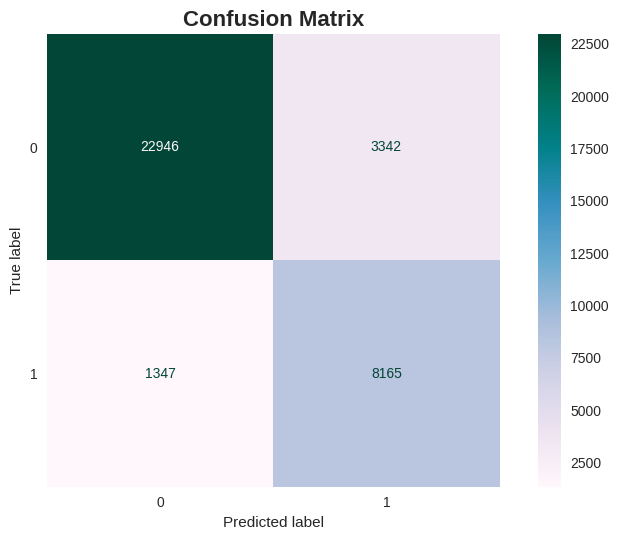

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_class_test, y_class_pred, cmap='PuBuGn')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.grid(False)
plt.tight_layout()
plt.show()


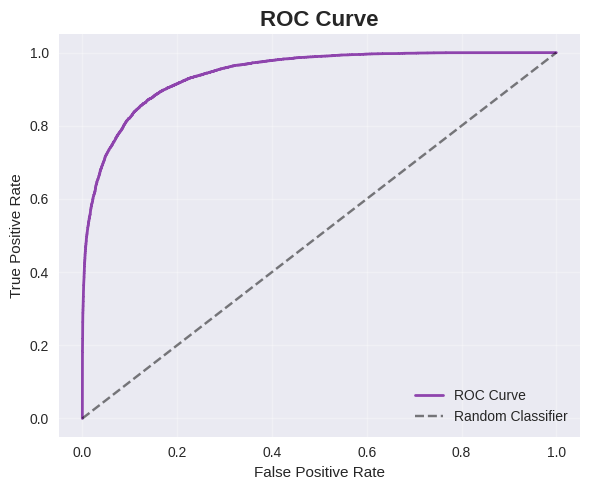

In [ ]:
fpr, tpr, _ = roc_curve(y_class_test, y_class_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='#8e44ad', linewidth=2, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


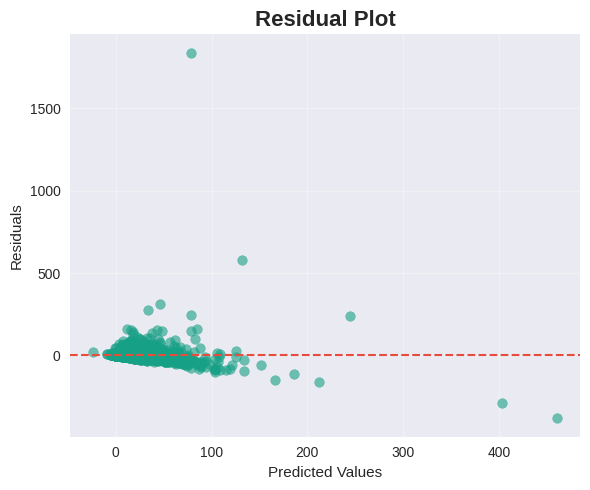

In [ ]:
residuals = y_reg_test - y_reg_pred
plt.figure(figsize=(6, 5))
plt.scatter(y_reg_pred, residuals, alpha=0.6, color='#16a085')
plt.axhline(y=0, color='#e74c3c', linestyle='--', linewidth=1.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


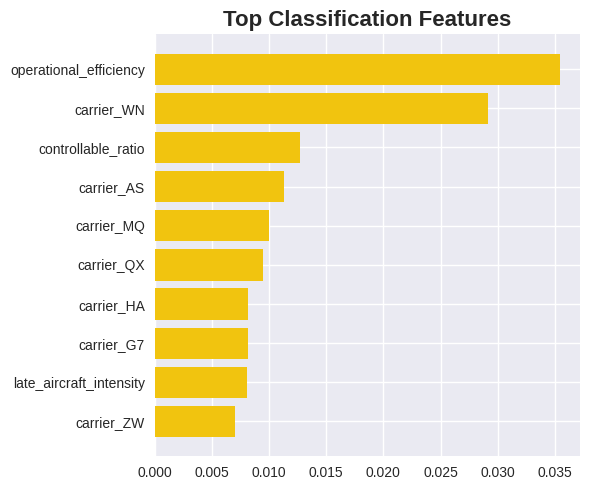

In [ ]:
feature_importance_class = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf_model.feature_importances_
}).sort_values('importance', ascending=True).tail(10)

plt.figure(figsize=(6, 5))
plt.barh(feature_importance_class['feature'], feature_importance_class['importance'], color='#f1c40f')
plt.title('Top Classification Features', fontsize=16, fontweight='bold')
plt.tick_params(axis='y', labelsize=10)
plt.tight_layout()
plt.show()


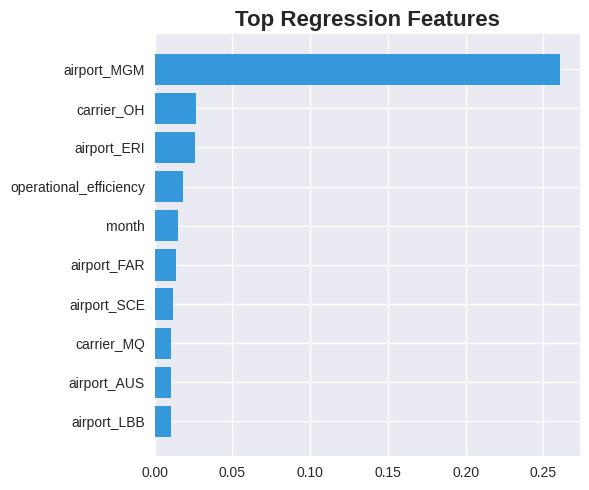

In [ ]:
feature_importance_reg = pd.DataFrame({
    'feature': X_train.columns,
    'importance': reg_model.feature_importances_
}).sort_values('importance', ascending=True).tail(10)

plt.figure(figsize=(6, 5))
plt.barh(feature_importance_reg['feature'], feature_importance_reg['importance'], color='#3498db')
plt.title('Top Regression Features', fontsize=16, fontweight='bold')
plt.tick_params(axis='y', labelsize=10)
plt.tight_layout()
plt.show()


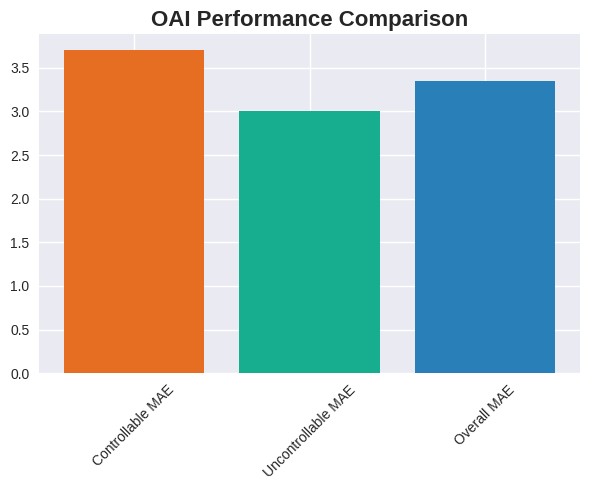

In [ ]:
plt.figure(figsize=(6, 5))
colors = ['#e66e22', '#17ae90', '#2980b9']
plt.bar(oai_comparison['Metric'], oai_comparison['Value'], color=colors)
plt.title('OAI Performance Comparison', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Feature Importance & SHAP Analysis**

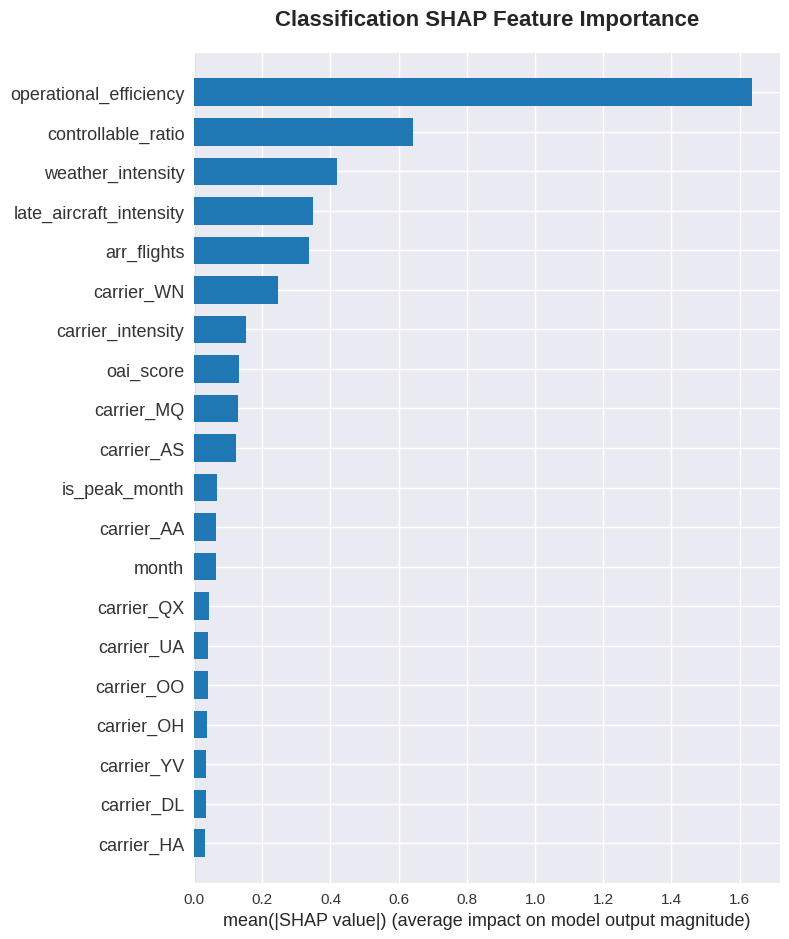

In [ ]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_class, X_test, plot_type='bar', show=False, color='#1f77b4')
plt.title('Classification SHAP Feature Importance', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


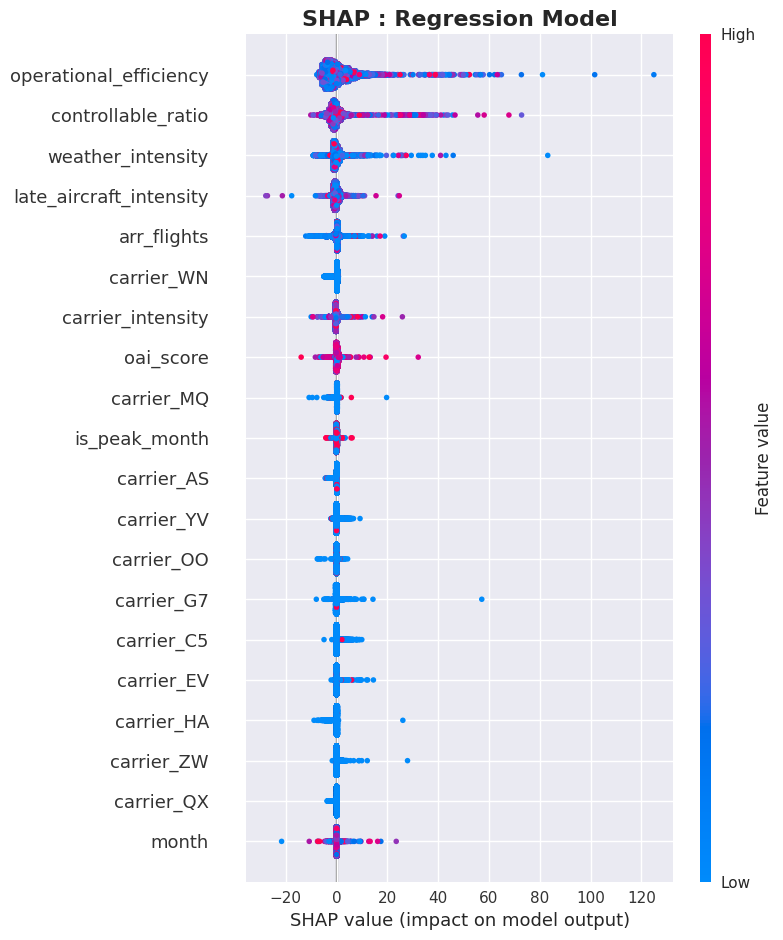

In [ ]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_reg, X_test, plot_type='dot', color_bar=True, show=False, color='#2a9d8f')
plt.title('SHAP : Regression Model', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


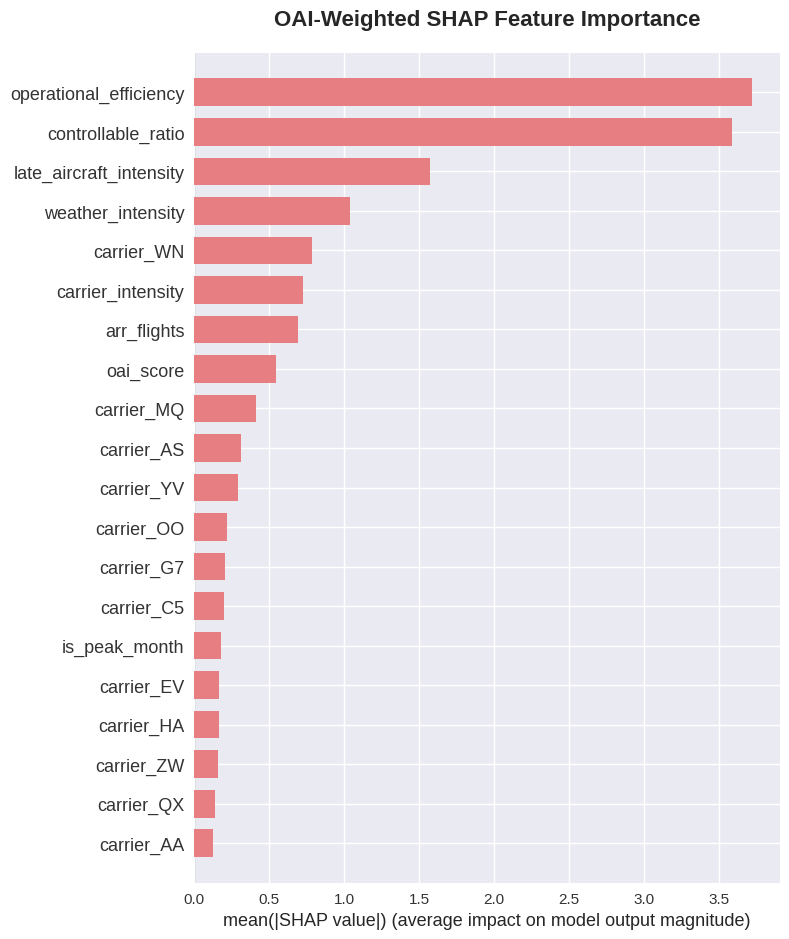

In [ ]:
plt.figure(figsize=(10, 6))
shap.summary_plot(weighted_shap_reg, X_test, plot_type='bar', show=False, color='#e77f82')
plt.title('OAI-Weighted SHAP Feature Importance', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


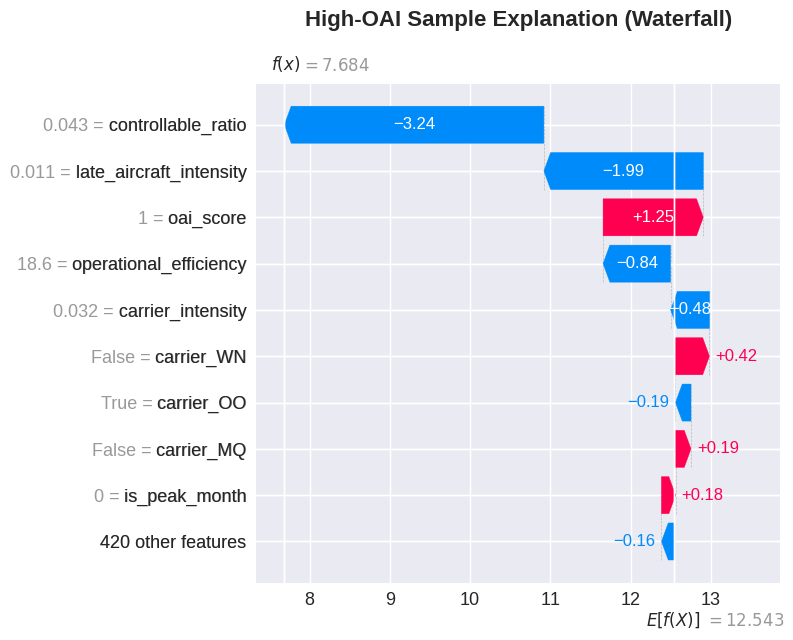

In [ ]:
sample_idx = np.where(weights_test > weights_test.quantile(0.8))[0][0]

shap_explanation = shap.Explanation(
    values=weighted_shap_reg[sample_idx],
    base_values=explainer_reg.expected_value,
    data=X_test.iloc[sample_idx],
    feature_names=X_test.columns.tolist()
)

plt.figure(figsize=(12, 6))
shap.plots.waterfall(shap_explanation, show=False)
plt.title('High-OAI Sample Explanation (Waterfall)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


In [ ]:
def generate_performance_report():
    report = {
        'Classification Metrics': {
            'Accuracy': accuracy_score(y_class_test, y_class_pred),
            'Precision': precision_score(y_class_test, y_class_pred),
            'Recall': recall_score(y_class_test, y_class_pred),
            'F1-Score': f1_score(y_class_test, y_class_pred),
            'ROC-AUC': roc_auc_score(y_class_test, y_class_prob)
        },
        'Regression Metrics': {
            'MAE': mae,
            'RMSE': rmse,
            'R² Score': reg_model.score(X_test, y_reg_test)
        },
        'OAI Metrics': oai_metrics
    }

    print("="*60)
    print("COMPREHENSIVE MODEL PERFORMANCE REPORT")
    print("="*60)

    for category, metrics in report.items():
        print(f"\n{category}:")
        print("-" * 40)
        for metric, value in metrics.items():
            print(f"{metric:.<30} {value:.4f}")

    return report

performance_report = generate_performance_report()


COMPREHENSIVE MODEL PERFORMANCE REPORT

Classification Metrics:
----------------------------------------
Accuracy...................... 0.8690
Precision..................... 0.7096
Recall........................ 0.8584
F1-Score...................... 0.7769
ROC-AUC....................... 0.9440

Regression Metrics:
----------------------------------------
MAE........................... 3.3493
RMSE.......................... 12.8399
R² Score...................... 0.3202

OAI Metrics:
----------------------------------------
OAI_MAE....................... 2.6496
Controllable_MAE.............. 3.7215
Uncontrollable_MAE............ 2.9771
OAI_Improvement............... -25.0019


In [ ]:
def extract_actionable_insights():
    controllable_impact = pd.DataFrame({
        'Feature': X_test.columns,
        'SHAP_Impact': np.abs(weighted_shap_reg).mean(axis=0),
        'Is_Controllable': [col in controllable_features for col in X_test.columns]
    }).sort_values('SHAP_Impact', ascending=False)

    print("\n" + "="*70)
    print("ACTIONABLE INSIGHTS FOR OPERATIONAL IMPROVEMENT")
    print("="*70)

    print("\n🔧 Top 5 High-Impact Controllable Features:")
    controllable_top = controllable_impact[controllable_impact['Is_Controllable']].head(5)
    for idx, row in controllable_top.iterrows():
        print(f"• {row['Feature']}: SHAP Impact Score = {row['SHAP_Impact']:.4f}")

    print(f"\n📊 OAI Model Performance Summary:")
    print(f"• Predictive focus on controllable delays improved by {oai_metrics['OAI_Improvement']:.1f}%")
    print(f"• MAE for controllable delay prediction: {oai_metrics['Controllable_MAE']:.3f} minutes")
    print(f"• Recommended focus areas: Carrier-level operations and aircraft turnaround processes")

    return controllable_impact

insights = extract_actionable_insights()



ACTIONABLE INSIGHTS FOR OPERATIONAL IMPROVEMENT

🔧 Top 5 High-Impact Controllable Features:
• controllable_ratio: SHAP Impact Score = 3.5848
• late_aircraft_intensity: SHAP Impact Score = 1.5738
• carrier_WN: SHAP Impact Score = 0.7869
• carrier_intensity: SHAP Impact Score = 0.7278
• oai_score: SHAP Impact Score = 0.5433

📊 OAI Model Performance Summary:
• Predictive focus on controllable delays improved by -25.0%
• MAE for controllable delay prediction: 3.721 minutes
• Recommended focus areas: Carrier-level operations and aircraft turnaround processes
